# Homicide Report 


Our overall objectives are to determine what factors tend to cause a homicide to go unsolved and to create a model to predict which homicides are likely to go unsolved. Our target audience consists police agencies who will be investigating these homicides and to the general public who are genuinly just intersted

We will analyze data from **The Murder Accountability Project**.


Homicide Case Data: https://www.kaggle.com/murderaccountability/homicide-reports

City Population Data: https://www.kaggle.com/max-mind/world-cities-database

# Imports

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from scipy.stats import mode
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

import seaborn as sns
import statsmodels.api as sm
%matplotlib inline


import xgboost as xgb

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/Shared drives/Project 3 - Data Science/'
graph_folder = '/content/drive/Shared drives/Project 3 - Data Science/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


# Loading the Data

In [18]:
df = pd.read_csv(drive_dir + 'database.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
df.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [20]:
df.shape

(638454, 24)

Description of each non self-explanatory column:
- `Incident` – A three-digit number describing the case number within the month in which a  homicide occurred. It is used to assist in building a unique record number for each case  and to differentiate each case reported within the same month.

- `Relationship` - Describing the relationship between the victim and  the perpetrator.

- `Weapon` -  The weapon used in the crime.

- `Victim Count` - The number of additional victims (not counting the victim included in the current record) included in the Supplementary Homicide Report’s incident record, which can accept up  to 10 additional victims in a single incident report.

- `Perpetrator Count` - The number of additional offenders (not counting the offender included in the  current record) included in the Supplementary Homicide Report’s incident record, which can  accept up to 10 additional offenders in a single incident report. 

# Cleaning the data


Changing columns to lower case and replacing spaces with under scores

In [21]:
def clean_col(col):
    col = col.strip()
    col = col.replace(" ", "_") 
    col = col.lower()
    return col
df.columns = [clean_col(c) for c in df.columns]

Our data set has no missing values however will will have to do further analysis to deterine if it contains unknown or strange values

In [22]:
for c in df.columns:
    num_missing = df[c].isna().sum()
    print(f'{c}: {num_missing} ({100*num_missing / df.shape[0]:.2f}%) missing values')

record_id: 0 (0.00%) missing values
agency_code: 0 (0.00%) missing values
agency_name: 0 (0.00%) missing values
agency_type: 0 (0.00%) missing values
city: 0 (0.00%) missing values
state: 0 (0.00%) missing values
year: 0 (0.00%) missing values
month: 0 (0.00%) missing values
incident: 0 (0.00%) missing values
crime_type: 0 (0.00%) missing values
crime_solved: 0 (0.00%) missing values
victim_sex: 0 (0.00%) missing values
victim_age: 0 (0.00%) missing values
victim_race: 0 (0.00%) missing values
victim_ethnicity: 0 (0.00%) missing values
perpetrator_sex: 0 (0.00%) missing values
perpetrator_age: 0 (0.00%) missing values
perpetrator_race: 0 (0.00%) missing values
perpetrator_ethnicity: 0 (0.00%) missing values
relationship: 0 (0.00%) missing values
weapon: 0 (0.00%) missing values
victim_count: 0 (0.00%) missing values
perpetrator_count: 0 (0.00%) missing values
record_source: 0 (0.00%) missing values


The column `perpetrator_age` was of the type object, so to use it as an actual age we must fill in missing values with 0 and convert to a int. 

In [23]:
df['perpetrator_age'] = df['perpetrator_age'].replace(' ', '0')

In [24]:
df['perpetrator_age'] = pd.to_numeric(df['perpetrator_age'])

In [25]:
df.head()

,record_id,agency_code,agency_name,agency_type,city,state,year,month,incident,crime_type,crime_solved,victim_sex,victim_age,victim_race,victim_ethnicity,perpetrator_sex,perpetrator_age,perpetrator_race,perpetrator_ethnicity,relationship,weapon,victim_count,perpetrator_count,record_source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


# Feature Engineering

This section documents the new columns we added to our data frame to help draw better conclusions in our analysis

####`same_race` 

- This column indicates if the perpetrator and the victim have the same race. 1, indicates same race. 0, indicates they do not have the same race.

In [26]:
df.loc[(df['victim_race']== df['perpetrator_race']), 'same_race'] = 1

In [27]:
df['same_race'] = df['same_race'].fillna(0)

In [28]:
df['same_race'].value_counts(normalize=True)

1.0    0.605741
0.0    0.394259
Name: same_race, dtype: float64

####`same_sex` 

- This column indicates if the perpetrator and the victim have the same sex. 1, indicates same sex. 0, indicates they do not have the same sex.

In [29]:
df.loc[(df['victim_sex']== df['perpetrator_sex']), 'same_sex'] = 1

In [30]:
df['same_sex'] = df['same_sex'].fillna(0)

In [31]:
df['same_sex'].value_counts(normalize=True)

0.0    0.512258
1.0    0.487742
Name: same_sex, dtype: float64

####`city_population`

 - This column tells us the population of the city, this gives us an indication of how urban/rural the city that the murder occured in. We added this in as research shows large cities tend to have higher incidences of unsolved murders than small towns.

In [32]:
df_cities = pd.read_csv(drive_dir + 'worldcities.csv')

In [33]:
df_cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


This data set contains 7328 cites in the US

In [34]:
df_cities = df_cities[df_cities['country'] == 'United States']
df_cities = df_cities.drop(['city_ascii', 'iso2', 'iso3','capital','id','country'], axis = 1)
df_cities.shape

(7328, 5)

In [35]:
df_cities.rename(columns={'admin_name':'state'}, inplace=True)

In [36]:
df_cities.head()

,city,lat,lng,state,population
1,New York,40.6943,-73.9249,New York,19354922.0
8,Los Angeles,34.1139,-118.4068,California,12815475.0
24,Chicago,41.8373,-87.6862,Illinois,8675982.0
40,Miami,25.7839,-80.2102,Florida,6381966.0
42,Dallas,32.7936,-96.7662,Texas,5733259.0


Our crime data set has 1782 cities

In [37]:
cityList = df['city'].unique()
df_cities = df_cities[df_cities['city'].isin(cityList)]

Merge the data frames togther useing a left join to join them by city and state. 

In [38]:
df_merged = pd.merge(df_cities, df, on=['city', 'state'], how='right')

In [39]:
df_merged.head()

,city,lat,lng,state,population,record_id,agency_code,agency_name,agency_type,year,month,incident,crime_type,crime_solved,victim_sex,victim_age,victim_race,victim_ethnicity,perpetrator_sex,perpetrator_age,perpetrator_race,perpetrator_ethnicity,relationship,weapon,victim_count,perpetrator_count,record_source,same_race,same_sex
0,Anchorage,61.1508,-149.1091,Alaska,253421.0,1,AK00101,Anchorage,Municipal Police,1980,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI,1.0,1.0
1,Anchorage,61.1508,-149.1091,Alaska,253421.0,2,AK00101,Anchorage,Municipal Police,1980,March,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,1.0,1.0
2,Anchorage,61.1508,-149.1091,Alaska,253421.0,3,AK00101,Anchorage,Municipal Police,1980,March,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI,0.0,0.0
3,Anchorage,61.1508,-149.1091,Alaska,253421.0,4,AK00101,Anchorage,Municipal Police,1980,April,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,1.0,1.0
4,Anchorage,61.1508,-149.1091,Alaska,253421.0,5,AK00101,Anchorage,Municipal Police,1980,April,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI,0.0,0.0


Assert that the merge was correct and we still have the correct number of rows 

In [40]:
assert len(df_merged) == len(df)

Unfortunatly the city population data set only gave us population data for 44% of the data.

In [41]:
df_merged['population'].isna().sum()/len(df_merged)

0.5659718632822411

We will fill in the rows with missing population data with the mean population

In [42]:
df_merged['population'] = df_merged['population'].fillna((df_merged['population'].median()))

For rows with missing lat/log we will simply enter 0.

In [43]:
df_merged['lat'] = df_merged['lat'].fillna(0)

In [44]:
df_merged['lng'] = df_merged['lng'].fillna(0)

Check to make sure there is no missing data

In [45]:
df_merged['population'].isna().sum()

0

Saving the merged data frame into the data framw we are working with. 

In [46]:
df=df_merged

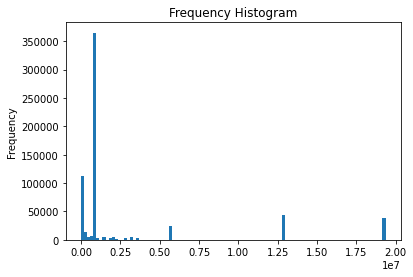

In [47]:
x = df['population']
plt.hist(x, bins=100)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

####`total_homicides`

- This column will contain the total count of homicides that occured within a city. This will give us insight into the population of a specific city.

In [48]:
state_count = df.groupby(['state','city']).size()

In [49]:
state_count_df = state_count.to_frame()

In [50]:
state_count_df.columns = ['total_homicides']

In [51]:
state_count_df.shape

(3042, 1)

In [52]:
df['city'].nunique()

1782

In [53]:
df_merged_total = pd.merge(state_count_df, df, on=['state','city'], how='right')

In [54]:
df_merged_total.tail()

,state,city,total_homicides,lat,lng,population,record_id,agency_code,agency_name,agency_type,year,month,incident,crime_type,crime_solved,victim_sex,victim_age,victim_race,victim_ethnicity,perpetrator_sex,perpetrator_age,perpetrator_race,perpetrator_ethnicity,relationship,weapon,victim_count,perpetrator_count,record_source,same_race,same_sex
638449,Nebraska,Antelope,2,0.0,0.0,833671.0,617629,NB00200,Antelope County,Sheriff,2012,December,1,Murder or Manslaughter,Yes,Male,30,White,Unknown,Male,33,White,Unknown,Unknown,Firearm,1,0,FBI,1.0,1.0
638450,Nebraska,Antelope,2,0.0,0.0,833671.0,617630,NB00200,Antelope County,Sheriff,2012,December,1,Murder or Manslaughter,Yes,Female,25,White,Unknown,Male,33,White,Unknown,Unknown,Firearm,1,0,FBI,1.0,0.0
638451,Ohio,Knox,1,0.0,0.0,833671.0,619639,OH04200,Knox County,Sheriff,2012,February,1,Murder or Manslaughter,No,Female,56,White,Unknown,Unknown,0,Unknown,Unknown,Unknown,Firearm,0,0,FBI,0.0,0.0
638452,Nebraska,Garfield,1,0.0,0.0,833671.0,632209,NBNSP36,St Ptrl: Garfield County,State Police,2014,January,1,Murder or Manslaughter,Yes,Female,2,White,Not Hispanic,Male,30,White,Not Hispanic,Daughter,Shotgun,0,0,FBI,1.0,0.0
638453,North Dakota,Steele,1,0.0,0.0,833671.0,632712,ND04600,Steele County,Sheriff,2014,February,1,Murder or Manslaughter,Yes,Male,66,White,Unknown,Female,60,White,Unknown,Husband,Drugs,0,0,FBI,1.0,0.0


In [55]:
df = df_merged_total

####`date` 

- This column stores the Month and Year information into a dateTime data point. 

In [56]:
month_dict = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8,
             'September': 9, 'October': 10, 'November': 11, 'December': 12}
df['month_number'] = df['month'].map(month_dict)

In [57]:
df['day'] = '1'

In [58]:
df['dateInt']=df['year'].astype(str) + df['month_number'].astype(str).str.zfill(2)+ df['day'].astype(str).str.zfill(2)
df['date'] = pd.to_datetime(df['dateInt'], format='%Y%m%d')

Drop the columns we had to add to create dates

In [59]:
df = df.drop(['dateInt', 'day'], axis = 1)

####`solved` and  `unsolved`

This will changed the solved column into two numerical values. 0 is no and 1 is yes.

In [60]:
solved_dic = {'Yes':1,'No':0}
df['solved'] = df['crime_solved'].map(solved_dic)

In [61]:
unsolved_dic = {'No':1,'Yes':0}
df['unsolved'] = df['crime_solved'].map(unsolved_dic)

####`victim_age_group` 

We will categorize victim ages.

In [62]:
def vicage(x):
  if x <= 13: 
    return 'child'
  if x>13 and x<=17:
    return 'teenager'
  if x >17 and x<=29:
    return 'young adult'
  if x>29 and x<=60:
    return 'adult'
  if x>60 and x<=100:
    return 'elder'
  if x>100: 
    return 'unknown'
    
df['victim_age_group'] = df['victim_age'].apply(vicage)

In [63]:
df['victim_age_group'].unique()

array(['teenager', 'adult', 'elder', 'young adult', 'child', 'unknown'],
      dtype=object)

In [64]:
solved_by_Vagegroup = df.groupby('victim_age_group')['solved'].sum()/df['victim_age_group'].value_counts()

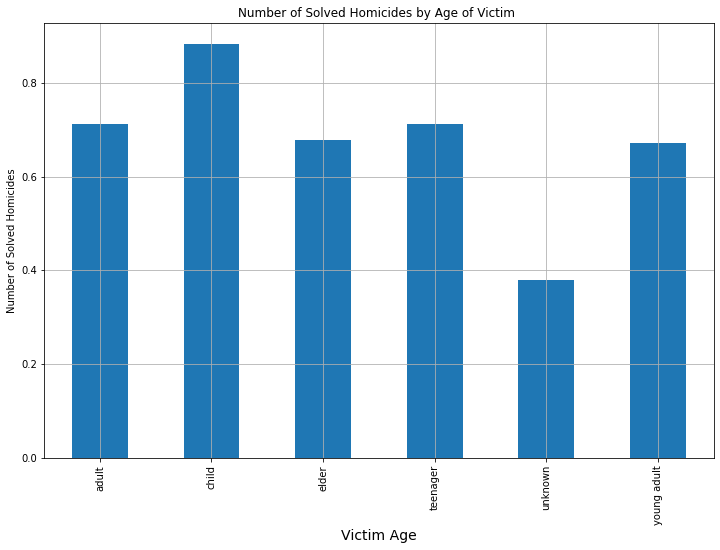

In [65]:
ax = solved_by_Vagegroup.plot(kind='bar', figsize=(12, 8), title='Number of Solved Homicides by Age of Victim ', grid=True)
ax.set_xlabel('Victim Age', fontsize=14)
ax.set_ylabel('Number of Solved Homicides');

In [66]:
unsolved_by_Vagegroup = df.groupby('victim_age_group')['unsolved'].sum()/df['victim_age_group'].value_counts()

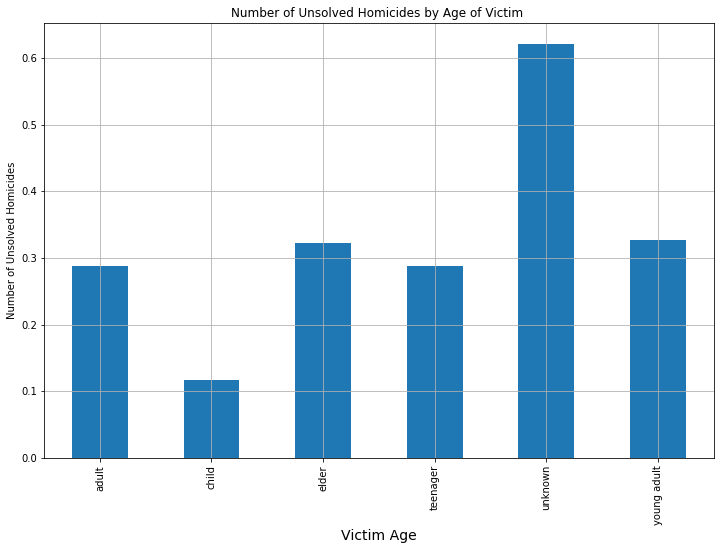

In [67]:
ax = unsolved_by_Vagegroup.plot(kind='bar', figsize=(12, 8), title='Number of Unsolved Homicides by Age of Victim ', grid=True)
ax.set_xlabel('Victim Age', fontsize=14)
ax.set_ylabel('Number of Unsolved Homicides');

####`perpetrator_age_group`

We will categorize perpetrator ages.

In [68]:
def perpage(x):
  if x <=5:
    return 'unknown'
  if x>5 and x <= 10: 
    return 'child'
  if x>10 and x<=19:
    return 'teenager'
  if x >19 and x<=29:
    return 'young adult'
  if x>29 and x<=60:
    return 'adult'
  if x>60 and x<=100:
    return 'elder'
    
df['perpetrator_age_group'] = df['perpetrator_age'].apply(perpage)

In [69]:
solved_by_Pagegroup = df.groupby('perpetrator_age_group')['solved'].sum()

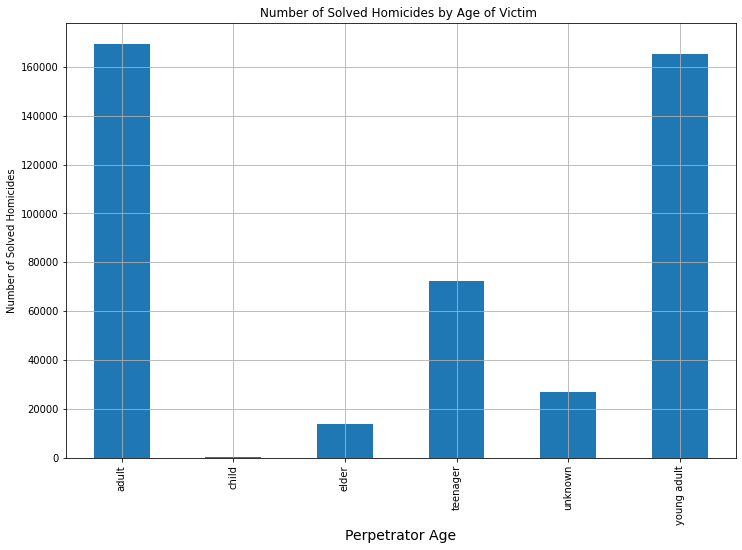

In [70]:
ax = solved_by_Pagegroup.plot(kind='bar', figsize=(12, 8), title='Number of Solved Homicides by Age of Victim ', grid=True)
ax.set_xlabel('Perpetrator Age', fontsize=14)
ax.set_ylabel('Number of Solved Homicides');

####`same_age`

If the victim and the perpetrator are in the same age group then the value is true == 1. 

In [71]:
df.loc[(df['victim_age_group']== df['perpetrator_age_group']), 'same_age'] = 1

In [72]:
df['same_age'] = df['same_age'].fillna(0)

In [73]:
df.head()

,state,city,total_homicides,lat,lng,population,record_id,agency_code,agency_name,agency_type,year,month,incident,crime_type,crime_solved,victim_sex,victim_age,victim_race,victim_ethnicity,perpetrator_sex,perpetrator_age,perpetrator_race,perpetrator_ethnicity,relationship,weapon,victim_count,perpetrator_count,record_source,same_race,same_sex,month_number,date,solved,unsolved,victim_age_group,perpetrator_age_group,same_age
0,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,1,AK00101,Anchorage,Municipal Police,1980,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI,1.0,1.0,1,1980-01-01,1,0,teenager,teenager,1.0
1,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,2,AK00101,Anchorage,Municipal Police,1980,March,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,1.0,1.0,3,1980-03-01,1,0,adult,adult,1.0
2,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,3,AK00101,Anchorage,Municipal Police,1980,March,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI,0.0,0.0,3,1980-03-01,0,1,adult,unknown,0.0
3,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,4,AK00101,Anchorage,Municipal Police,1980,April,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,1.0,1.0,4,1980-04-01,1,0,adult,adult,1.0
4,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,5,AK00101,Anchorage,Municipal Police,1980,April,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI,0.0,0.0,4,1980-04-01,0,1,adult,unknown,0.0


####`weapon_gun`

- This column indicates wheter the murder occured with a gun or not 

In [74]:
df['weapon'].unique()

array(['Blunt Object', 'Strangulation', 'Unknown', 'Rifle', 'Knife',
       'Firearm', 'Shotgun', 'Fall', 'Handgun', 'Fire', 'Drugs',
       'Explosives', 'Drowning', 'Gun', 'Suffocation', 'Poison'],
      dtype=object)

In [75]:
df.loc[(df['weapon']== 'Rifle'), 'weapon_gun'] = 1
df.loc[(df['weapon']== 'Firearm'), 'weapon_gun'] = 1
df.loc[(df['weapon']== 'Shotgun'), 'weapon_gun'] = 1
df.loc[(df['weapon']== 'Handgun'), 'weapon_gun'] = 1
df.loc[(df['weapon']== 'Gun'), 'weapon_gun'] = 1

In [76]:
df['weapon_gun'] = df['weapon_gun'].fillna(0)

In [77]:
df.head()

,state,city,total_homicides,lat,lng,population,record_id,agency_code,agency_name,agency_type,year,month,incident,crime_type,crime_solved,victim_sex,victim_age,victim_race,victim_ethnicity,perpetrator_sex,perpetrator_age,perpetrator_race,perpetrator_ethnicity,relationship,weapon,victim_count,perpetrator_count,record_source,same_race,same_sex,month_number,date,solved,unsolved,victim_age_group,perpetrator_age_group,same_age,weapon_gun
0,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,1,AK00101,Anchorage,Municipal Police,1980,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI,1.0,1.0,1,1980-01-01,1,0,teenager,teenager,1.0,0.0
1,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,2,AK00101,Anchorage,Municipal Police,1980,March,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,1.0,1.0,3,1980-03-01,1,0,adult,adult,1.0,0.0
2,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,3,AK00101,Anchorage,Municipal Police,1980,March,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI,0.0,0.0,3,1980-03-01,0,1,adult,unknown,0.0,0.0
3,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,4,AK00101,Anchorage,Municipal Police,1980,April,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,1.0,1.0,4,1980-04-01,1,0,adult,adult,1.0,0.0
4,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,5,AK00101,Anchorage,Municipal Police,1980,April,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI,0.0,0.0,4,1980-04-01,0,1,adult,unknown,0.0,0.0


In [78]:
df.to_csv(drive_dir + 'clean_data.csv', index = False)



# Analysis, Part 1

We will save the solved and unsolved cases into thier own data frames to complete comparitive anaysis. 

In [79]:
df['crime_solved'].value_counts(normalize = True)

Yes    0.701964
No     0.298036
Name: crime_solved, dtype: float64

In [80]:
df_solved = df[df['crime_solved']=='Yes']
df_unsolved = df[df['crime_solved']=='No']

In [81]:
import seaborn as sns
def plotComparingColumn(df_solved, df_unsolved, column):
  solved_pct = df_solved.groupby(column)[column].count() / len(df_solved)
  solved_df = pd.DataFrame(solved_pct)
  solved_df.columns = ['percentage']
  solved_df['crime_solved'] = True

  unsolved_pct = df_unsolved.groupby(column)[column].count() / len(df_unsolved)
  unsolved_df = pd.DataFrame(unsolved_pct)
  unsolved_df.columns = ['percentage']
  unsolved_df['crime_solved'] = False

  joined_df = pd.concat([unsolved_df, solved_df])
  joined_df.columns = ['percentage', 'crime_solved']
  joined_df = joined_df.reset_index()
  ax = sns.barplot(y=column, x="percentage", hue="crime_solved", data=joined_df)

This data set has 638,454 recorded homicides

In [82]:
df.shape

(638454, 38)

###`crime_solved`

70% of the recorded homicides were solved. Leaving 30% unsolved. We will be exploring what factors can help predict if a case will be unsolved and as we see our data is not too unbalanced in this aspect. 

In [83]:
df['crime_solved'].value_counts(normalize = True)

Yes    0.701964
No     0.298036
Name: crime_solved, dtype: float64

###`agency_type`

77% of the homicide cases were processed by the Municipal Police 

In [84]:
df['agency_type'].value_counts(normalize = True)

Municipal Police    0.772219
Sheriff             0.164964
County Police       0.035544
State Police        0.022296
Special Police      0.004525
Regional Police     0.000368
Tribal Police       0.000085
Name: agency_type, dtype: float64

In this graph we can see that cases seen by the Sherrif and State Police had a higher chance of being solved. Where as cases handeled by the County Police and Municipal Police were more likely to go unsolved.

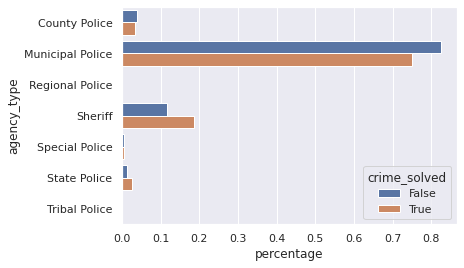

In [206]:
plotComparingColumn(df_solved, df_unsolved, 'agency_type')

###`incident`

The incident value is used to assist in building a unique record number for each case and to differentiate each case reported within the same month. As this is acting to assist in generating a unique identifyer we do not feel it has any attributes that will predict if case is unsolved. 

In [86]:
df['incident'].value_counts(normalize = True)

1      0.415892
2      0.112426
3      0.061455
4      0.042467
5      0.032356
         ...   
784    0.000025
783    0.000025
782    0.000025
781    0.000025
0      0.000025
Name: incident, Length: 1000, dtype: float64

In [87]:
df_incident = df[df['incident']==1]

We see that 41% of cases have the incident number of 1 and of those rows the spilt of solved and unsolved cases is really close to the overall percentage. Thus this values does not provide any insight.

In [88]:
df_incident['crime_solved'].value_counts(normalize = True)

Yes    0.788459
No     0.211541
Name: crime_solved, dtype: float64

###`weapon`

There are 16 unique weapons used in each of the homicides

In [89]:
df['weapon'].nunique()

16

Handguns are used most frequently as almost 50% of homicides had a handgun as the murder weapon. 

In [90]:
df['weapon'].value_counts(normalize= True)

Handgun          0.497270
Knife            0.148737
Blunt Object     0.105469
Firearm          0.073584
Unknown          0.051988
Shotgun          0.048119
Rifle            0.036568
Strangulation    0.012703
Fire             0.009669
Suffocation      0.006215
Gun              0.003455
Drugs            0.002487
Drowning         0.001886
Explosives       0.000841
Poison           0.000711
Fall             0.000298
Name: weapon, dtype: float64

In this plot we see that murders commited with Blunt Objects, Knives, Rifle, and Shotgun all had a higher percentage of crimes that were unsolved. 

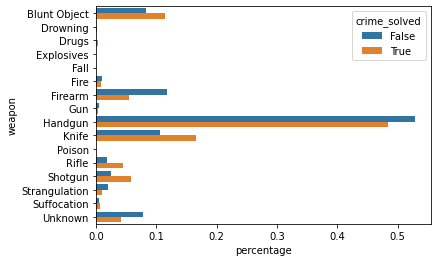

In [91]:
plotComparingColumn(df_solved, df_unsolved, 'weapon')
plt.savefig('Solve-unsolved weapon bar.png', bbox_inches='tight')

65% of the solved cases involved a gun as the murder weapon

In [92]:
df['weapon_gun'].value_counts(normalize= True)

1.0    0.658997
0.0    0.341003
Name: weapon_gun, dtype: float64

###`relationship`

There are 28 unique relationships between the victim and perpetrator. We think relationship could have some impact on a case being solved as if someone with no criminal ties and no enemies is murdered, it is difficult to ascertain the reason. When it is difficult to determine the motive, the case is more likely to go unsolved.

In [93]:
df['relationship'].nunique()

28

42% of our data is missing the relationship between the victim and perpetrator. Also there appear to be a few relationships that provide the same information like; 'Boyfriend/Girlfriend', 'Boyfriend', 'Girlfriend'. We could combine these all to 'Boyfriend/Girlfriend'.

In [94]:
df['relationship'].value_counts(normalize= True)

Unknown                 0.427616
Acquaintance            0.197380
Stranger                0.151292
Wife                    0.036317
Friend                  0.034372
Girlfriend              0.025789
Son                     0.015512
Family                  0.014935
Husband                 0.013788
Daughter                0.011808
Boyfriend               0.011437
Neighbor                0.009858
Brother                 0.008636
Father                  0.006831
Mother                  0.006654
In-Law                  0.005697
Common-Law Wife         0.003880
Ex-Wife                 0.003090
Common-Law Husband      0.003061
Boyfriend/Girlfriend    0.002166
Stepfather              0.002130
Sister                  0.002024
Stepson                 0.001833
Stepdaughter            0.001181
Ex-Husband              0.000985
Employer                0.000797
Employee                0.000601
Stepmother              0.000330
Name: relationship, dtype: float64

###`record_source`

96% of the homicide cases are sourced from the FBI records.  

In [95]:
df['record_source'].value_counts(normalize= True)

FBI     0.965844
FOIA    0.034156
Name: record_source, dtype: float64

In [96]:
df_solved['record_source'].value_counts(normalize= True)

FBI     0.964902
FOIA    0.035098
Name: record_source, dtype: float64

In [97]:
df_unsolved['record_source'].value_counts(normalize= True)

FBI     0.968063
FOIA    0.031937
Name: record_source, dtype: float64

The record source appears to have no effect on if a case is solved or unsolved.

###`crime_type`

All of the data we have are records of homicides, 98% of those homicides are murder/manslaughter. The remaining 2% were manslaughter by negligence. 

In [98]:
df['crime_type'].value_counts(normalize= True)

Murder or Manslaughter        0.985722
Manslaughter by Negligence    0.014278
Name: crime_type, dtype: float64

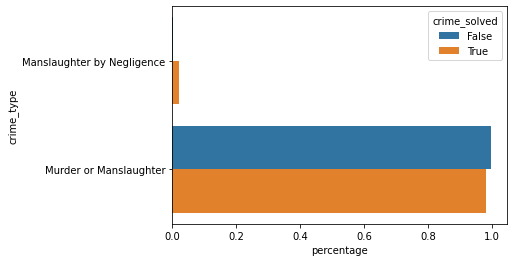

In [99]:
plotComparingColumn(df_solved, df_unsolved, 'crime_type')

###`perpetrator_age`

There are 100 unique ages of perpetrators, however we see ages like 0,1,2,3.. which are very young to be murderers. In the history of the US the youngest recorded murderer is 6, in 2000. Thus all ages younger than 6 we will change to be unknown. 

In [100]:
df['perpetrator_age'].value_counts(normalize= True)

0     0.338831
20    0.033871
19    0.031717
21    0.029733
18    0.029499
        ...   
95    0.000014
98    0.000011
96    0.000011
2     0.000009
97    0.000005
Name: perpetrator_age, Length: 100, dtype: float64

In [101]:
df['perpetrator_age'].unique()

array([15, 42,  0, 36, 27, 35, 40, 49, 39, 29, 19, 20, 31, 22, 21, 45, 17,
       50, 30, 26, 37, 33, 34, 23, 24, 41, 18, 43, 13, 47, 28, 14, 56, 25,
       38, 48, 44, 71, 32, 16, 46, 53, 59, 54, 55, 58, 84, 11, 12, 51, 72,
       65, 63, 62, 66, 73, 61, 64, 69,  7, 57,  9, 52, 10, 78,  2,  5,  8,
       67,  6, 60, 90, 76, 68, 77, 74, 75, 82, 83, 70, 80, 79, 86, 92, 81,
       87, 91, 93, 89, 85,  4, 99, 88, 94,  3,  1, 96, 95, 98, 97])

In [102]:
df['victim_age'].value_counts(normalize= True)

22    0.036101
20    0.036073
25    0.035929
21    0.035705
23    0.035144
        ...   
94    0.000182
95    0.000128
97    0.000061
96    0.000058
98    0.000052
Name: victim_age, Length: 101, dtype: float64

In [103]:
df['victim_age'].unique()

array([ 14,  43,  30,  42,  99,  32,  38,  36,  20,  48,  31,  16,  24,
        21,  35,  18,  33,  28,  34,  41,  23,  45,  19,  62,  40,  29,
        74,  22,   0,  26,  50,  51,  25,  37,  27,  44,  52,  73,  47,
        76,  70,  58,  55,  17,  15,  60,   7,  57,   3,  53,  39,   2,
        69,  66,  12,   1,  63,   4,   8,  46,   5,  54,   9,  65,  82,
        10,  59,  56,  13,  72,  11,  49,  61,  75,  67,  71,  64,  81,
        85,  79,   6,  77,  83,  84, 998,  68,  90,  78,  80,  87,  88,
        94,  92,  91,  95,  98,  93,  89,  86,  96,  97])

In [104]:
df_solved['perpetrator_age'].min()

0

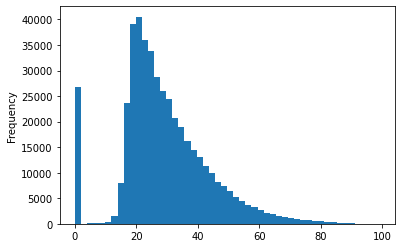

In [105]:
df_solved['perpetrator_age'].plot(kind = 'hist',bins=50)

###`city`

The homicides that occured in this data set took place at 1,782 different cites across the US.

In [106]:
df['city'].nunique()

1782

In [107]:
df_solved['city'].nunique()

1775

In [108]:
df_unsolved['city'].nunique()

1505

###`state`

The homicides that occured in this data set took place at 51 different states across the US. Where the District of Columbia is the 51st state being included.

In [109]:
df['state'].nunique()

51

In [110]:
df['state'].unique()

array(['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'District of Columbia', 'Delaware',
       'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois',
       'Indiana', 'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts',
       'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Missouri',
       'Mississippi', 'Montana', 'Nebraska', 'North Carolina',
       'North Dakota', 'New Hampshire', 'New Jersey', 'New Mexico',
       'Nevada', 'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhodes Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Virginia', 'Vermont', 'Washington', 'Wisconsin',
       'West Virginia', 'Wyoming'], dtype=object)

In [111]:
df['state'].value_counts()

California              99783
Texas                   62095
New York                49268
Florida                 37164
Michigan                28448
Illinois                25871
Pennsylvania            24236
Georgia                 21088
North Carolina          20390
Louisiana               19629
Ohio                    19158
Maryland                17312
Virginia                15520
Tennessee               14930
Missouri                14832
New Jersey              14132
Arizona                 12871
South Carolina          11698
Indiana                 11463
Alabama                 11376
Oklahoma                 8809
Washington               7815
District of Columbia     7115
Arkansas                 6947
Colorado                 6593
Kentucky                 6554
Mississippi              6546
Wisconsin                6191
Massachusetts            6036
Nevada                   5553
Connecticut              4896
New Mexico               4272
Oregon                   4217
Minnesota 

### Age Categories

####Analyzing the Victim age group

In [112]:
df['victim_age_group'].value_counts()

adult          269690
young adult    252661
elder           50944
teenager        32679
child           31506
unknown           974
Name: victim_age_group, dtype: int64

In [113]:
solved_by_Vagegroup = df.groupby('victim_age_group')['solved'].sum()/df['victim_age_group'].value_counts ()

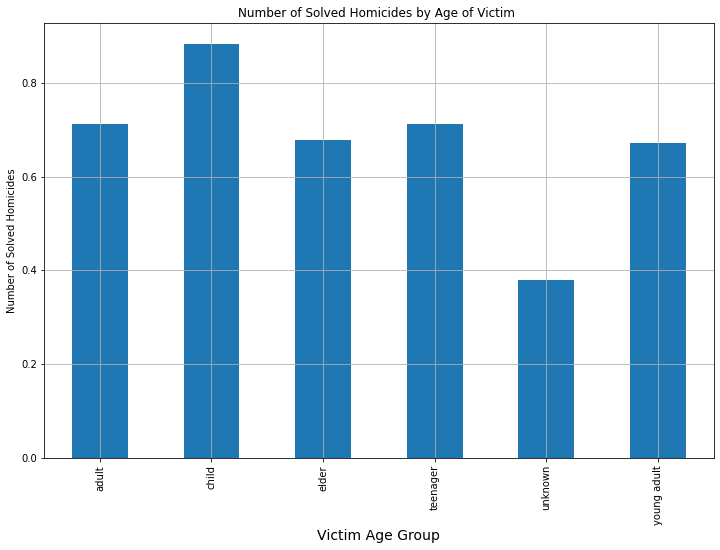

In [114]:
ax = solved_by_Vagegroup.plot(kind='bar', figsize=(12, 8), title='Number of Solved Homicides by Age of Victim ', grid=True)
ax.set_xlabel('Victim Age Group', fontsize=14)
ax.set_ylabel('Number of Solved Homicides');

In [115]:
unsolved_by_Vagegroup = df.groupby('victim_age_group')['unsolved'].sum()/df['victim_age_group'].value_counts ()

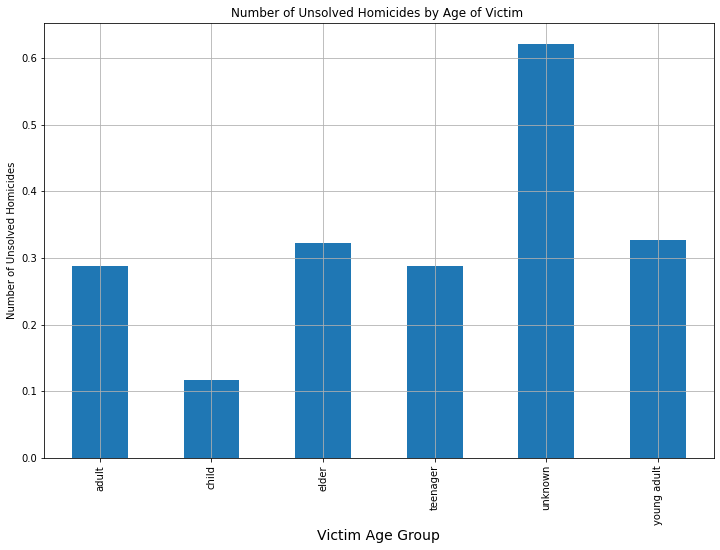

In [116]:
ax = unsolved_by_Vagegroup.plot(kind='bar', figsize=(12, 8), title='Number of Unsolved Homicides by Age of Victim ', grid=True)
ax.set_xlabel('Victim Age Group', fontsize=14)
ax.set_ylabel('Number of Unsolved Homicides');

####Analyzing the Perpetrator age group

In [117]:
df['perpetrator_age_group'].value_counts()

unknown        216454
adult          169572
young adult    165364
teenager        72534
elder           14139
child             391
Name: perpetrator_age_group, dtype: int64

In [118]:
solved_by_Pagegroup = df.groupby('perpetrator_age_group')['solved'].sum()

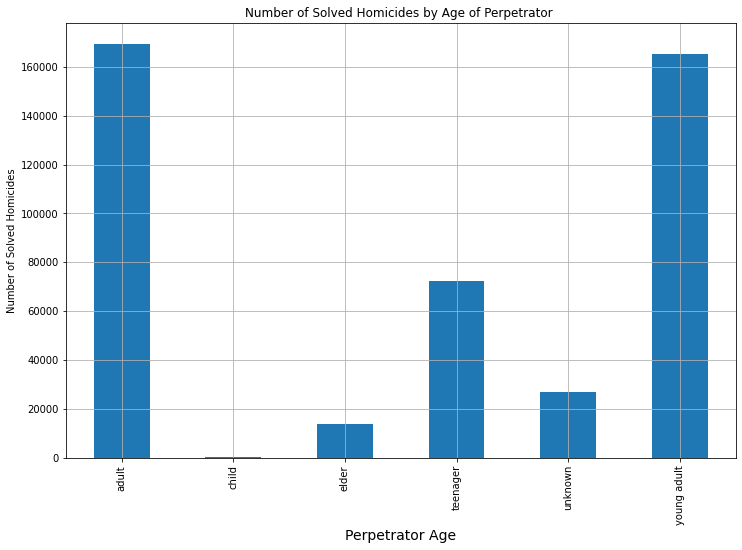

In [119]:
ax = solved_by_Pagegroup.plot(kind='bar', figsize=(12, 8), title='Number of Solved Homicides by Age of Perpetrator ', grid=True)
ax.set_xlabel('Perpetrator Age', fontsize=14)
ax.set_ylabel('Number of Solved Homicides');

# Analysis, Part 2

## Perpetrator Analysis 


### Perpetrator Age

In [120]:
df['perpetrator_age'].nunique()

100

In [121]:
df['perpetrator_age'].unique()

array([15, 42,  0, 36, 27, 35, 40, 49, 39, 29, 19, 20, 31, 22, 21, 45, 17,
       50, 30, 26, 37, 33, 34, 23, 24, 41, 18, 43, 13, 47, 28, 14, 56, 25,
       38, 48, 44, 71, 32, 16, 46, 53, 59, 54, 55, 58, 84, 11, 12, 51, 72,
       65, 63, 62, 66, 73, 61, 64, 69,  7, 57,  9, 52, 10, 78,  2,  5,  8,
       67,  6, 60, 90, 76, 68, 77, 74, 75, 82, 83, 70, 80, 79, 86, 92, 81,
       87, 91, 93, 89, 85,  4, 99, 88, 94,  3,  1, 96, 95, 98, 97])

In [122]:
df['perpetrator_age'].value_counts()

0     216328
20     21625
19     20250
21     18983
18     18834
       ...  
95         9
98         7
96         7
2          6
97         3
Name: perpetrator_age, Length: 100, dtype: int64

In [123]:
df['perpetrator_age'].min()

0

In [124]:
df['perpetrator_age'].max()

99

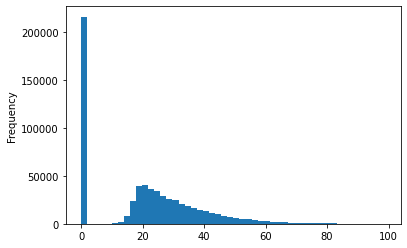

In [125]:
df['perpetrator_age'].plot(kind = 'hist', bins = 50)

### Perpetrator Sex

In [126]:
df['perpetrator_sex'].unique()

array(['Male', 'Unknown', 'Female'], dtype=object)

In [127]:
df.groupby(['perpetrator_sex', 'perpetrator_race'])['perpetrator_race'].count()

perpetrator_sex  perpetrator_race             
Female           Asian/Pacific Islander              577
                 Black                             24648
                 Native American/Alaska Native       578
                 Unknown                             403
                 White                             22342
Male             Asian/Pacific Islander             5449
                 Black                            189736
                 Native American/Alaska Native      3017
                 Unknown                            5502
                 White                            195837
Unknown          Asian/Pacific Islander               20
                 Black                               132
                 Native American/Alaska Native         7
                 Unknown                          190142
                 White                                64
Name: perpetrator_race, dtype: int64

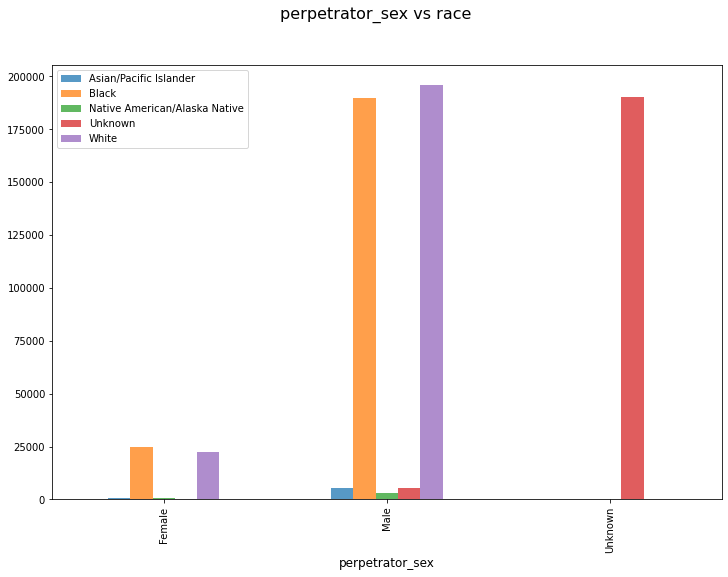

In [128]:
# sex by race
fig, ax = plt.subplots(figsize=(12,8))
df.groupby(['perpetrator_sex', 'perpetrator_race'])['perpetrator_race'].count().unstack().plot(ax=ax, kind='bar', alpha=0.75, legend=True)
fig.suptitle('perpetrator_sex vs race', fontsize=16)
plt.xlabel('perpetrator_sex', fontsize=12)
L=plt.legend()

In [129]:
sex_race_df = df.groupby(['perpetrator_sex', 'perpetrator_race'])['perpetrator_race'].count()
# sex_race_df.plot.pie(title="Perpetrator Sex & Race", legend=False, autopct='%1.1f%%', startangle=0, figsize=(12,12), pctdistance=1.2, labeldistance=1.3)

In [130]:
# sex_race_df.plot.pie( autopct='%.2f', fontsize=20, figsize=(12, 8))

In [131]:
sex_race_df

perpetrator_sex  perpetrator_race             
Female           Asian/Pacific Islander              577
                 Black                             24648
                 Native American/Alaska Native       578
                 Unknown                             403
                 White                             22342
Male             Asian/Pacific Islander             5449
                 Black                            189736
                 Native American/Alaska Native      3017
                 Unknown                            5502
                 White                            195837
Unknown          Asian/Pacific Islander               20
                 Black                               132
                 Native American/Alaska Native         7
                 Unknown                          190142
                 White                                64
Name: perpetrator_race, dtype: int64

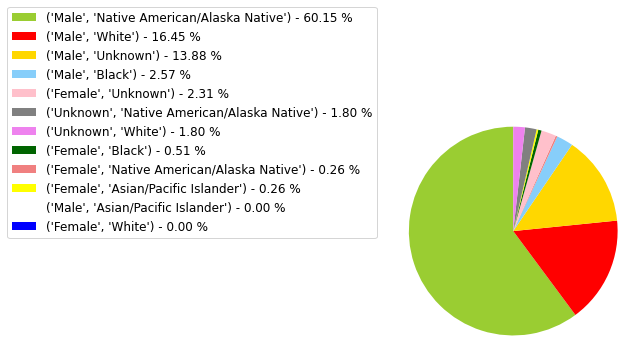

In [132]:
sexList = ['Male', 'Female', 'Unknown']
perp_race = ['Native American/Alaska Native', 'White', 'Unknown', 'Black',
              'Asian/Pacific Islander']
colors = ['yellowgreen','red','gold','lightskyblue','white','lightcoral',
          'blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
perp_sex_raceList = [(sex,race) for sex in sexList for race in perp_race]
x = perp_sex_raceList 
y = np.array([234, 64, 54,10, 0, 1, 0, 9, 2, 1, 7, 7])
percent = 100.*y/y.sum()
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 1.), fontsize=12)
plt.savefig('piechart.png', bbox_inches='tight')
# plt.figure(figsize=(12,12))

### Trend between perp sex and relationship?

In [133]:
df.groupby(['perpetrator_sex', 'relationship'])['relationship'].count()

perpetrator_sex  relationship        
Female           Acquaintance              8726
                 Boyfriend                 7043
                 Boyfriend/Girlfriend       196
                 Brother                    480
                 Common-Law Husband        1891
                                          ...  
Unknown          Stepfather                   2
                 Stepson                      1
                 Stranger                  9231
                 Unknown                 178206
                 Wife                        44
Name: relationship, Length: 81, dtype: int64

In [134]:
women_only = df[df['perpetrator_sex']=='Female']
men_only = df[df['perpetrator_sex']=='Male']
unknown_only = df[df['perpetrator_sex']=='Unknown']

In [135]:
womenPerp_relation = women_only.groupby(['relationship']).size()
menPerp_relation = men_only.groupby(['relationship']).size()
unknownPerp_relation = unknown_only.groupby(['relationship']).size()

In [136]:
def barplotFigure(df, titleName, labelName, xLabel, yLabel):
  fig = plt.figure(figsize=(12, 8))
  ax = df.plot(kind='bar', legend=True, alpha=0.5, label=labelName)
  fig.suptitle(titleName, fontsize=20)
  plt.xlabel(xLabel, fontsize=12)
  plt.xticks(rotation=85)
  plt.ylabel(yLabel, fontsize=12)

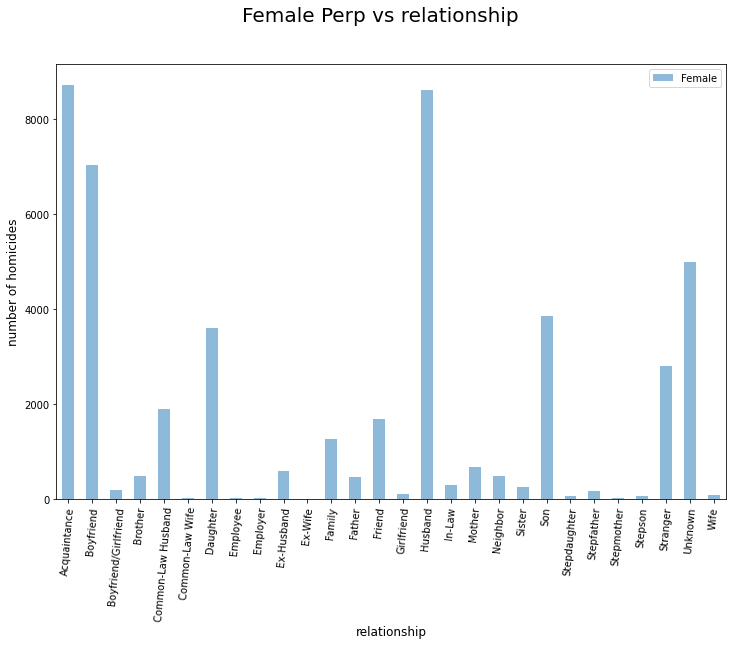

In [137]:
barplotFigure(df=womenPerp_relation, titleName = 'Female Perp vs relationship', labelName='Female', xLabel='relationship', yLabel='number of homicides')
plt.savefig(graph_folder + 'graphs/FperpRelation.png', format = 'png', transparent=False)

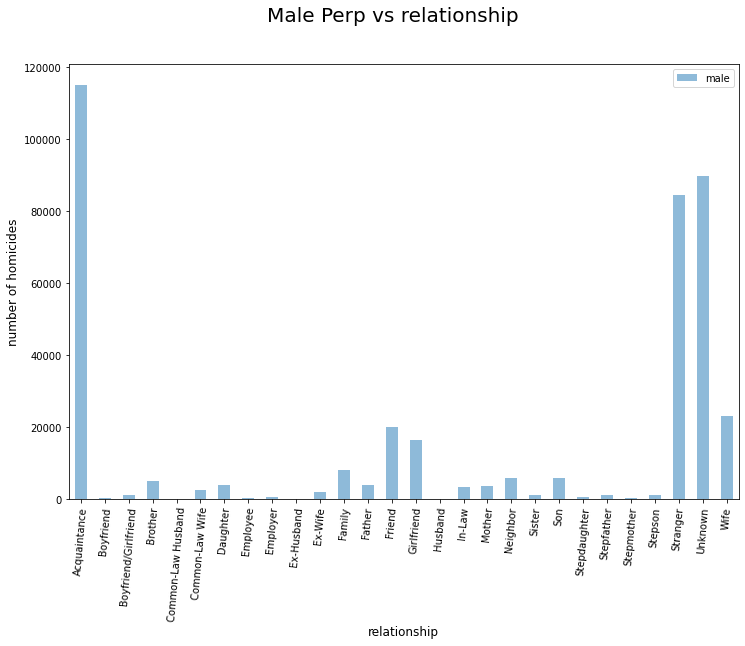

In [138]:
barplotFigure(df=menPerp_relation, titleName='Male Perp vs relationship', labelName='male', xLabel='relationship', yLabel='number of homicides')
plt.savefig(graph_folder + 'graphs/MperpRelation.png', format = 'png', transparent=False)

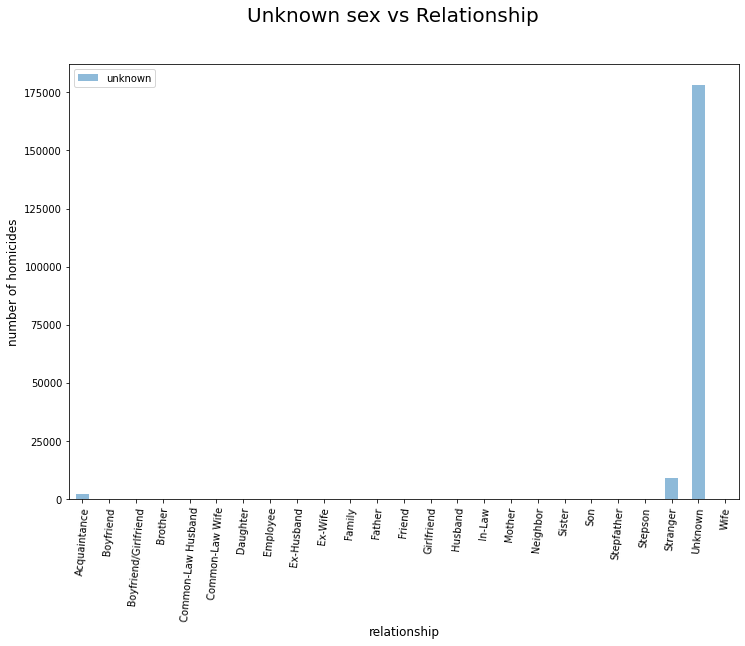

In [139]:
barplotFigure(df=unknownPerp_relation, titleName='Unknown sex vs Relationship', labelName='unknown', xLabel='relationship', yLabel='number of homicides')

Text(0, 0.5, 'Number of Homicides')

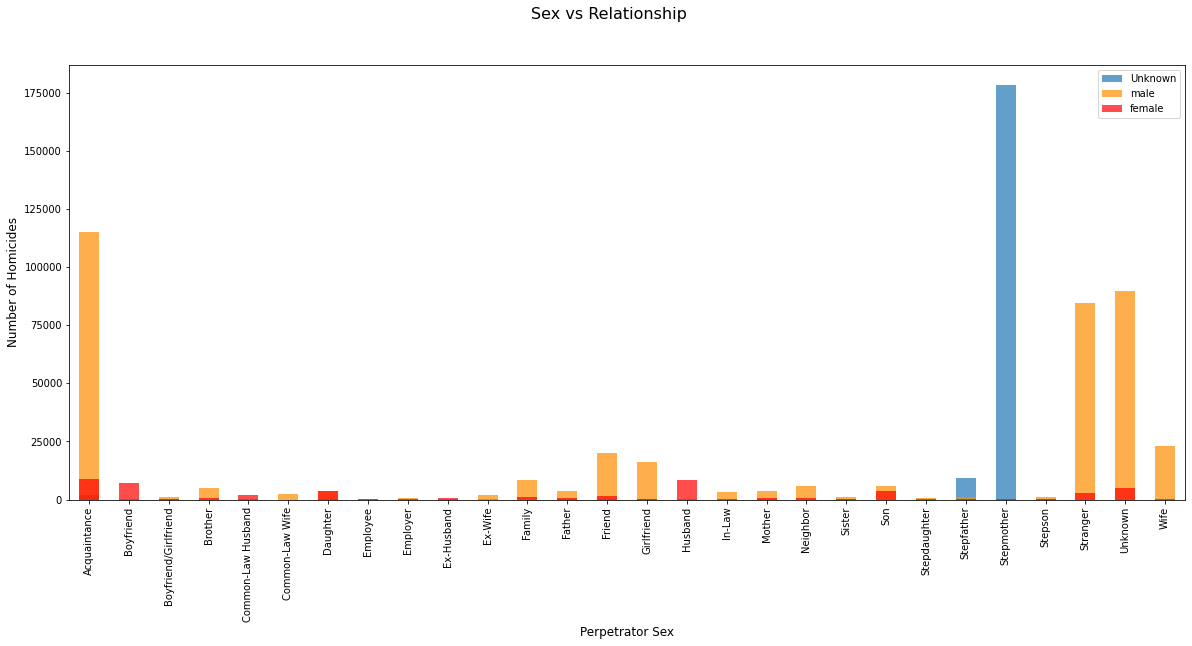

In [140]:
fig = plt.figure(figsize=(20, 8)) 
ax = unknownPerp_relation.plot(kind='bar', legend=True, alpha=0.7, label='Unknown')
menPerp_relation.plot(kind='bar', color= 'darkorange', legend=True, alpha=0.7, label='male')
womenPerp_relation.plot(kind='bar', color= 'red', legend=True, alpha=0.7, label='female')
fig.suptitle('Sex vs Relationship', fontsize=16)
plt.xlabel('Perpetrator Sex', fontsize=12)
plt.ylabel('Number of Homicides', fontsize=12)

In [141]:
df['relationship'].value_counts()

Unknown                 273013
Acquaintance            126018
Stranger                 96593
Wife                     23187
Friend                   21945
Girlfriend               16465
Son                       9904
Family                    9535
Husband                   8803
Daughter                  7539
Boyfriend                 7302
Neighbor                  6294
Brother                   5514
Father                    4361
Mother                    4248
In-Law                    3637
Common-Law Wife           2477
Ex-Wife                   1973
Common-Law Husband        1954
Boyfriend/Girlfriend      1383
Stepfather                1360
Sister                    1292
Stepson                   1170
Stepdaughter               754
Ex-Husband                 629
Employer                   509
Employee                   384
Stepmother                 211
Name: relationship, dtype: int64

In [142]:
def numOfHomicides(df):
  for relation in df:
    pct = df / df.sum() * 100
  print(f'{relation}: {pct}')

In [143]:
numOfHomicides(womenPerp_relation)

85: relationship
Acquaintance            17.973964
Boyfriend               14.507292
Boyfriend/Girlfriend     0.403724
Brother                  0.988712
Common-Law Husband       3.895114
Common-Law Wife          0.039137
Daughter                 7.421521
Employee                 0.067974
Employer                 0.067974
Ex-Husband               1.213232
Ex-Wife                  0.010299
Family                   2.595370
Father                   0.974293
Friend                   3.466672
Girlfriend               0.201862
Husband                 17.743264
In-Law                   0.605586
Mother                   1.415094
Neighbor                 0.996951
Sister                   0.517014
Son                      7.948834
Stepdaughter             0.125649
Stepfather               0.372827
Stepmother               0.051495
Stepson                  0.140068
Stranger                 5.792206
Unknown                 10.288786
Wife                     0.175084
dtype: float64


In [144]:
numOfHomicides(menPerp_relation)

23058: relationship
Acquaintance            28.814565
Boyfriend                0.061320
Boyfriend/Girlfriend     0.271562
Brother                  1.255441
Common-Law Husband       0.014016
Common-Law Wife          0.613454
Daughter                 0.972116
Employee                 0.086850
Employer                 0.119137
Ex-Husband               0.009261
Ex-Wife                  0.490813
Family                   2.054107
Father                   0.971114
Friend                   5.014504
Girlfriend               4.083436
Husband                  0.041047
In-Law                   0.834458
Mother                   0.888770
Neighbor                 1.445158
Sister                   0.259548
Son                      1.497468
Stepdaughter             0.173449
Stepfather               0.294588
Stepmother               0.046553
Stepson                  0.275566
Stranger                21.161783
Unknown                 22.478794
Wife                     5.771122
dtype: float64


In [145]:
numOfHomicides(unknownPerp_relation)

44: relationship
Acquaintance             1.137814
Boyfriend                0.007354
Boyfriend/Girlfriend     0.053581
Brother                  0.009456
Common-Law Husband       0.003677
Common-Law Wife          0.003677
Daughter                 0.027316
Employee                 0.002101
Ex-Husband               0.001576
Ex-Wife                  0.003677
Family                   0.035721
Father                   0.004202
Friend                   0.119245
Girlfriend               0.027316
Husband                  0.013133
In-Law                   0.004728
Mother                   0.005253
Neighbor                 0.018911
Sister                   0.002101
Son                      0.032569
Stepfather               0.001051
Stepson                  0.000525
Stranger                 4.849106
Unknown                 93.612796
Wife                     0.023113
dtype: float64


In [146]:
pct_women = womenPerp_relation / womenPerp_relation.sum() * 100
pct_men = menPerp_relation / menPerp_relation.sum() * 100
pct_unknown = unknownPerp_relation / unknownPerp_relation.sum() * 100

In [147]:
# relationList=[]
# for relation in women_only['relationship']:
#   if relation not in relationList:
#     relationList.append(relation)

Text(0.5, 0, 'Relationships')

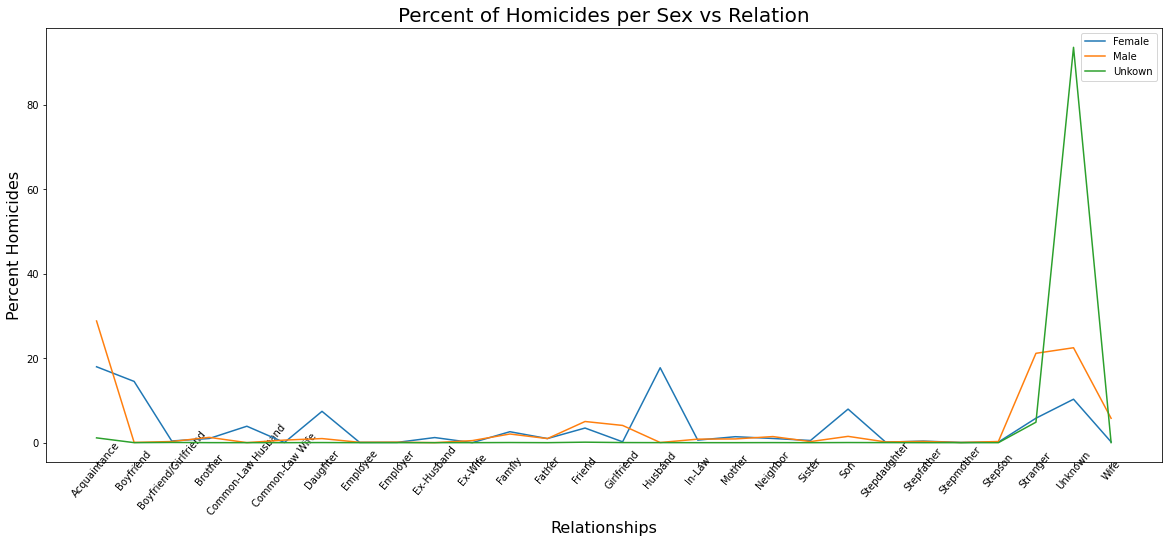

In [148]:
plt.figure(figsize=(20,8))
plt.plot(pct_women.index, pct_women, label='Female')
plt.plot(pct_men.index, pct_men, label= 'Male')
plt.plot(pct_unknown.index, pct_unknown, label= 'Unkown')
plt.xticks(rotation=50, verticalalignment = 'center')
plt.title('Percent of Homicides per Sex vs Relation', fontsize=20)
plt.legend()
plt.ylabel('Percent Homicides', fontsize=16)
plt.xlabel('Relationships', fontsize=16)
# plt.grid()

In [149]:
totalHomicides = womenPerp_relation.sum() + menPerp_relation.sum() + unknownPerp_relation.sum()

In [150]:
female_pct_homicides = womenPerp_relation.sum() / totalHomicides * 100
male_pct_homicides = menPerp_relation.sum() / totalHomicides * 100
unknown_pct_homicides = unknownPerp_relation.sum() / totalHomicides * 100

print(f'Percent female perpetrator homicides is: {female_pct_homicides}')
print(f'Percent male perpetrator homicides is: {male_pct_homicides}')
print(f'Percent unknown perpetrator homicides is: {unknown_pct_homicides}')

Percent female perpetrator homicides is: 7.603993396548538
Percent male perpetrator homicides is: 62.57944973326192
Percent unknown perpetrator homicides is: 29.816556870189554


### What races have the highest percentage for victims and the perp?

In [151]:
df.groupby(['victim_race']).size()

victim_race
Asian/Pacific Islander             9890
Black                            299899
Native American/Alaska Native      4567
Unknown                            6676
White                            317422
dtype: int64

In [152]:
df.groupby(['perpetrator_race']).size()

perpetrator_race
Asian/Pacific Islander             6046
Black                            214516
Native American/Alaska Native      3602
Unknown                          196047
White                            218243
dtype: int64

In [153]:
df.groupby(['victim_race']).size() / df['victim_race'].count() * 100

victim_race
Asian/Pacific Islander            1.549054
Black                            46.972687
Native American/Alaska Native     0.715322
Unknown                           1.045651
White                            49.717286
dtype: float64

In [154]:
df.groupby(['perpetrator_race']).size() / df['perpetrator_race'].count() * 100

perpetrator_race
Asian/Pacific Islander            0.946975
Black                            33.599288
Native American/Alaska Native     0.564175
Unknown                          30.706519
White                            34.183042
dtype: float64

In [155]:
df.groupby(['perpetrator_race', 'victim_race']).size()

perpetrator_race               victim_race                  
Asian/Pacific Islander         Asian/Pacific Islander             3859
                               Black                               561
                               Native American/Alaska Native        32
                               Unknown                              62
                               White                              1532
Black                          Asian/Pacific Islander             1249
                               Black                            179258
                               Native American/Alaska Native       411
                               Unknown                             963
                               White                             32635
Native American/Alaska Native  Asian/Pacific Islander               34
                               Black                               191
                               Native American/Alaska Native      2006
                

### Is there a trend between weapons used and the relationship between perp?

In [156]:
df.groupby(['relationship', 'weapon'])['weapon'].count()

relationship  weapon       
Acquaintance  Blunt Object     13681
              Drowning           135
              Drugs              373
              Explosives          55
              Fall                53
                               ...  
Wife          Rifle             1432
              Shotgun           2259
              Strangulation      500
              Suffocation        207
              Unknown            730
Name: weapon, Length: 407, dtype: int64

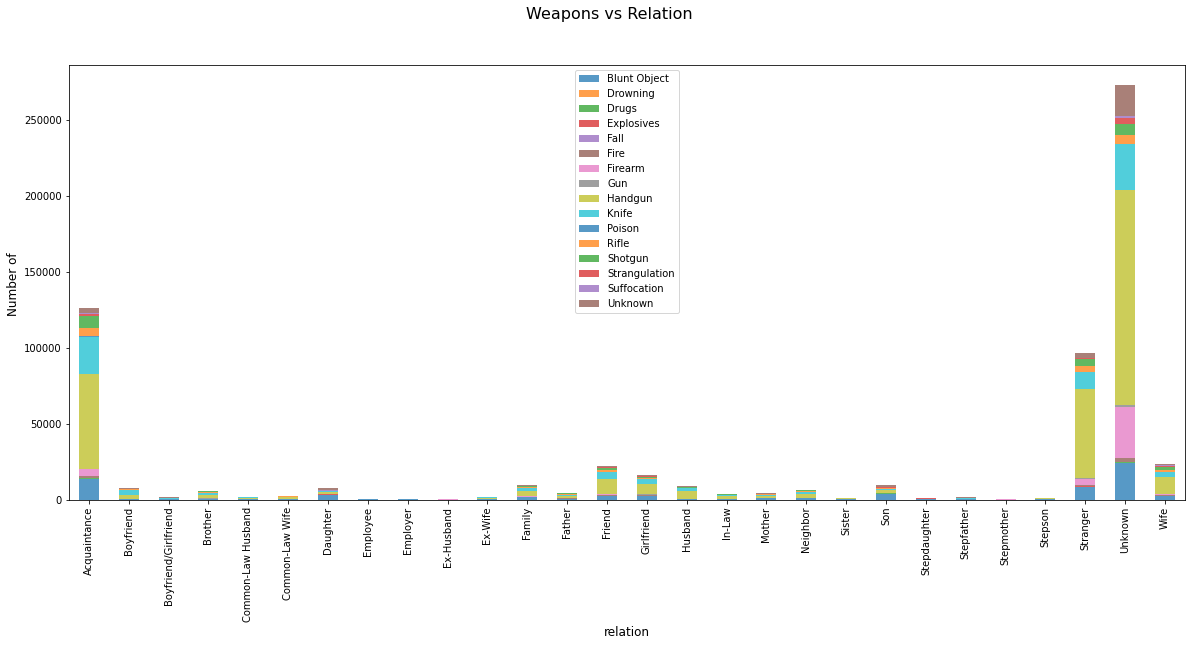

In [157]:
fig, ax = plt.subplots(figsize=(20,8))
df.groupby(['relationship', 'weapon']).size().unstack().plot(ax=ax, stacked=True, kind='bar', alpha=0.75, legend=True)
fig.suptitle('Weapons vs Relation', fontsize=16)
plt.xlabel('relation', fontsize=12)
plt.ylabel('Number of ', fontsize=12)
L=plt.legend()
plt.show()

### Is there a trend between the weapon used and perp demographics?

In [158]:
df.groupby(['perpetrator_age', 'perpetrator_race', 'weapon']).size()

perpetrator_age  perpetrator_race        weapon      
0                Asian/Pacific Islander  Blunt Object      8
                                         Drugs             1
                                         Fire              4
                                         Firearm          12
                                         Handgun         140
                                                        ... 
99               White                   Blunt Object      4
                                         Firearm           3
                                         Handgun           4
                                         Knife             1
                                         Unknown           3
Length: 3756, dtype: int64

In [159]:
df['perpetrator_race'].unique()

array(['Native American/Alaska Native', 'White', 'Unknown', 'Black',
       'Asian/Pacific Islander'], dtype=object)

In [160]:
perpdemo_weapon = df.groupby(['perpetrator_age', 'perpetrator_race', 'weapon']).size()

In [161]:
perpdemo_weapon.head(10)

perpetrator_age  perpetrator_race        weapon       
0                Asian/Pacific Islander  Blunt Object       8
                                         Drugs              1
                                         Fire               4
                                         Firearm           12
                                         Handgun          140
                                         Knife             27
                                         Rifle              6
                                         Shotgun            1
                                         Strangulation      3
                                         Suffocation        1
dtype: int64

In [162]:
df.groupby(['perpetrator_race', 'weapon']).size()

perpetrator_race        weapon       
Asian/Pacific Islander  Blunt Object       676
                        Drowning            26
                        Drugs               15
                        Explosives           9
                        Fall                 5
                                         ...  
White                   Rifle            13023
                        Shotgun          15890
                        Strangulation     2725
                        Suffocation       1982
                        Unknown          10782
Length: 79, dtype: int64

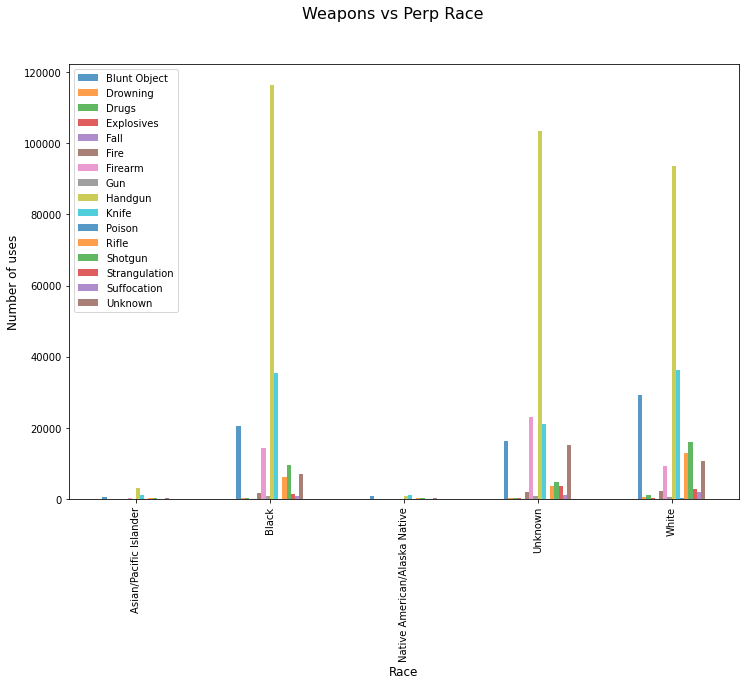

In [163]:
fig, ax = plt.subplots(figsize=(12,8))
df.groupby(['perpetrator_race', 'weapon']).size().unstack().plot(ax=ax, kind='bar', alpha=0.75, legend=True)
fig.suptitle('Weapons vs Perp Race', fontsize=16)
plt.xlabel('Race', fontsize=12)
plt.ylabel('Number of uses', fontsize=12)
L=plt.legend()

In [164]:
nativeRace = df[df['perpetrator_race']=='Native American/Alaska Native']
whiteRace = df[df['perpetrator_race']=='White']
unknownRace = df[df['perpetrator_race']=='Unknown']
blackRace = df[df['perpetrator_race']=='Black']
asianRace = df[df['perpetrator_race']=='Asian/Pacific Islander']

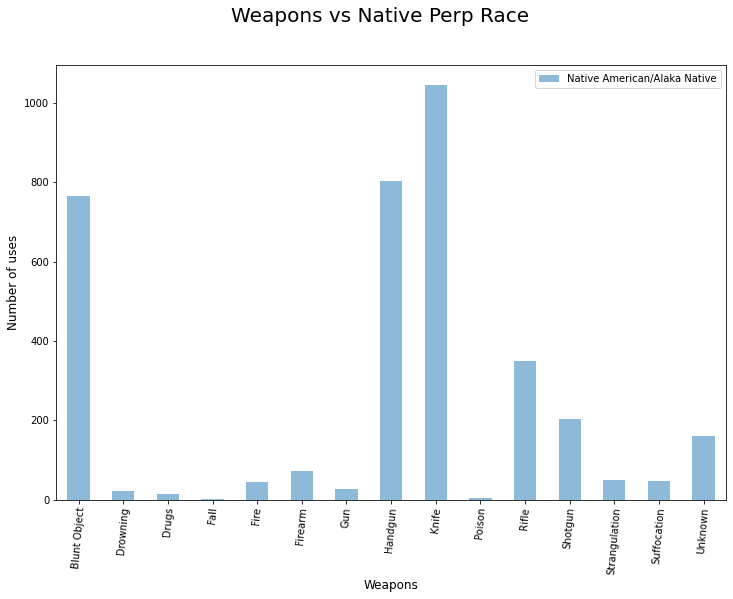

In [165]:
barplotFigure(df=nativeRace.groupby(['weapon']).size(), titleName='Weapons vs Native Perp Race', labelName='Native American/Alaka Native', xLabel='Weapons', yLabel='Number of uses')

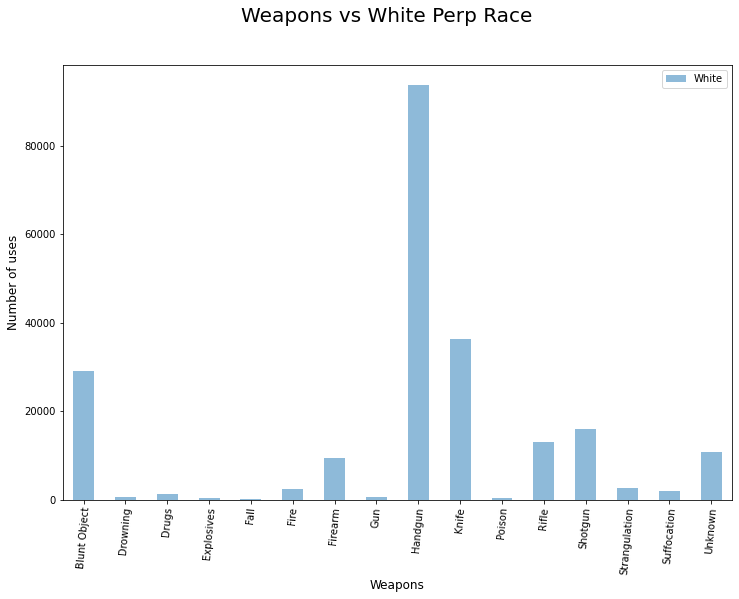

In [166]:
barplotFigure(df=whiteRace.groupby(['weapon']).size(), titleName='Weapons vs White Perp Race', labelName='White', xLabel='Weapons', yLabel='Number of uses')

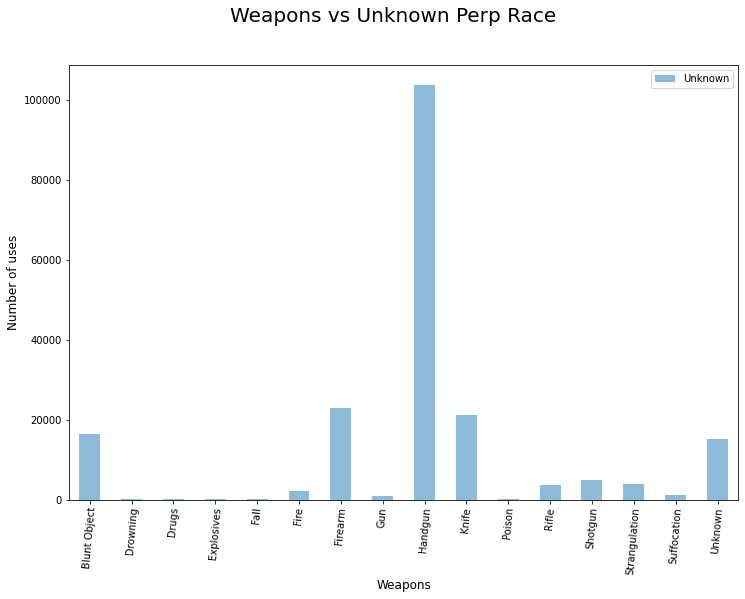

In [167]:
barplotFigure(df=unknownRace.groupby(['weapon']).size(), titleName='Weapons vs Unknown Perp Race', labelName='Unknown', xLabel='Weapons', yLabel='Number of uses')

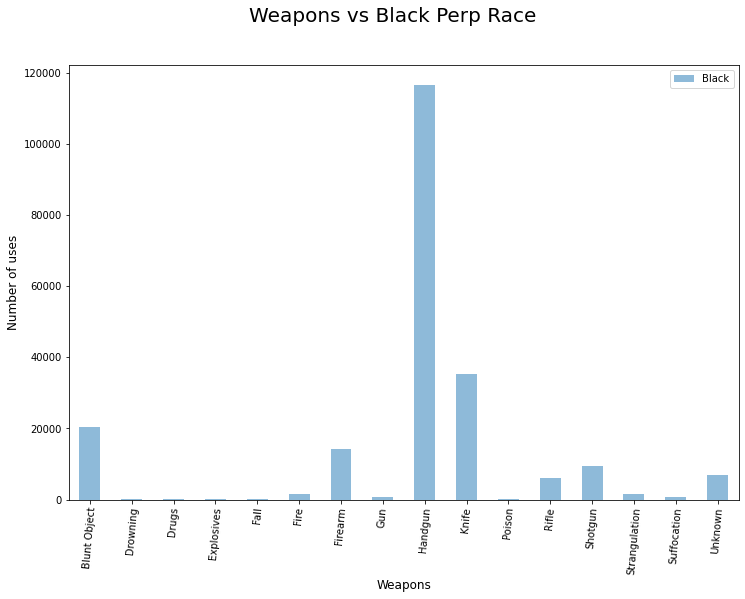

In [168]:
barplotFigure(df=blackRace.groupby(['weapon']).size(), titleName='Weapons vs Black Perp Race', labelName='Black', xLabel='Weapons', yLabel='Number of uses')

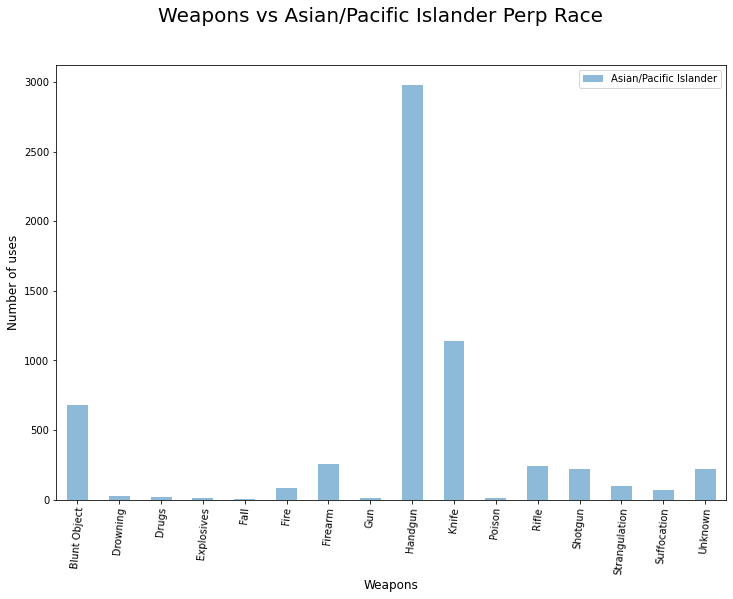

In [169]:
barplotFigure(df=asianRace.groupby(['weapon']).size(), titleName='Weapons vs Asian/Pacific Islander Perp Race', labelName='Asian/Pacific Islander', xLabel='Weapons', yLabel='Number of uses')

In [170]:
pct_wepons_native = nativeRace.groupby(['weapon']).size() / nativeRace['weapon'].count() * 100
pct_wepons_white = whiteRace.groupby(['weapon']).size() / whiteRace['weapon'].count() * 100
pct_wepons_unknown = unknownRace.groupby(['weapon']).size() / unknownRace['weapon'].count() * 100
pct_wepons_black = blackRace.groupby(['weapon']).size() / blackRace['weapon'].count() * 100
pct_wepons_asian = asianRace.groupby(['weapon']).size() / asianRace['weapon'].count() * 100

Text(0.5, 0, 'Weapons')

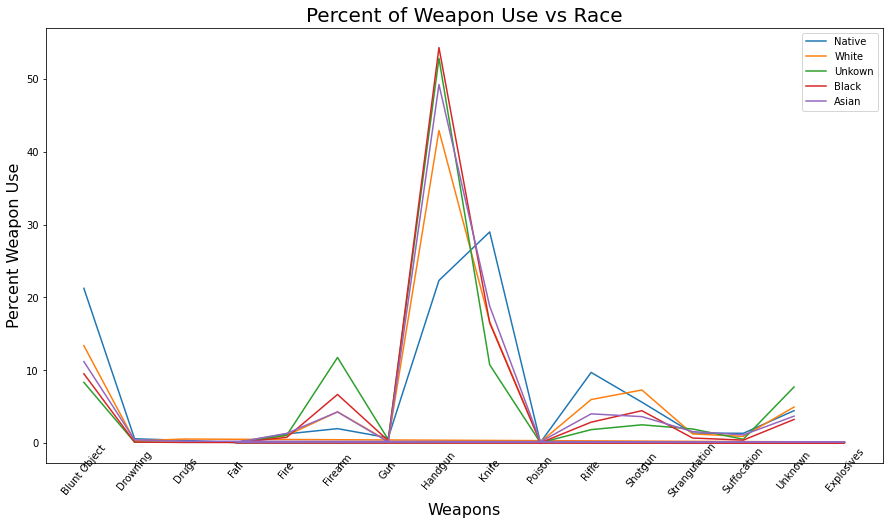

In [171]:
plt.figure(figsize=(15,8))
plt.plot(pct_wepons_native.index, pct_wepons_native, label='Native')
plt.plot(pct_wepons_white.index, pct_wepons_white, label= 'White')
plt.plot(pct_wepons_unknown.index, pct_wepons_unknown, label= 'Unkown')
plt.plot(pct_wepons_black.index, pct_wepons_black, label= 'Black')
plt.plot(pct_wepons_asian.index, pct_wepons_asian, label= 'Asian')
plt.xticks(rotation=50, verticalalignment = 'center')
plt.title('Percent of Weapon Use vs Race', fontsize=20)
plt.legend()
plt.ylabel('Percent Weapon Use', fontsize=16)
plt.xlabel('Weapons', fontsize=16)
# plt.grid()

In [172]:
def lineplot(df, title, labelName):
  plt.figure(figsize=(15,8))
  plt.plot(df.index, df, label=labelName)
  plt.xticks(rotation=50, verticalalignment = 'center')
  plt.title(title, fontsize=20)
  plt.legend()
  plt.ylabel('Percent Weapon Use', fontsize=16)
  plt.xlabel('Weapons', fontsize=16)
  # plt.grid()

In [173]:
# lineplot(pct_wepons_native, title='Native Race vs weapon use', labelName='Native American/Alaska Native')

In [174]:
# lineplot(pct_wepons_white, title='White Race vs wepon use', labelName='White')

In [175]:
# lineplot(pct_wepons_black, title='Black Race vs wepon use', labelName='Black')

In [176]:
# lineplot(pct_wepons_unknown, title='Unknown Race vs wepon use', labelName='unknown')

In [177]:
# lineplot(pct_wepons_asian, title='Asian/Pacific Islander Race vs wepon use', labelName='Asian/Pacific Islander')

## Further analysis

In [178]:
def descriptionHeatmap(df1, df2, titleName):
  plt.figure(figsize=(12,8),facecolor='#efefef')
  sns.set()
  ax = sns.heatmap(pd.crosstab(df1,df2).apply(lambda r: r/r.sum(), axis=1), 
                  annot=True, fmt=".0%", linewidths=.5,cmap='Blues')
  ax.set_title(titleName)
  cbar = ax.collections[0].colorbar
  cbar.set_ticks([0, .25, .50, .75, 1])
  cbar.set_ticklabels(['0%', '25%', '50%',  '75%', '100%'])

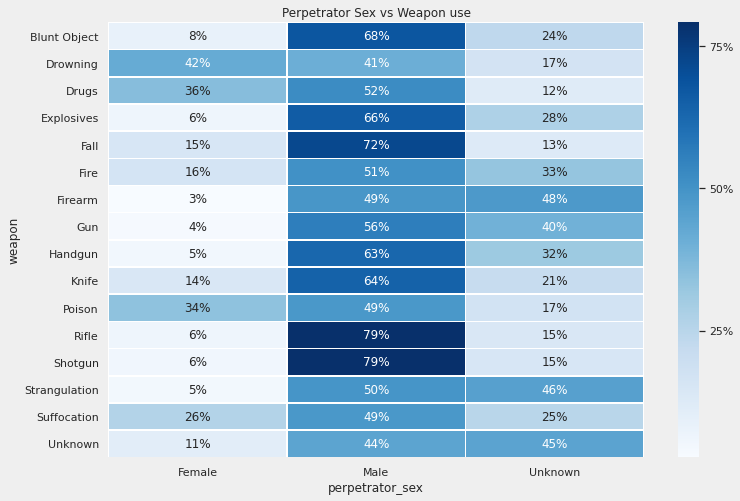

In [179]:
descriptionHeatmap(df1=df.weapon, df2=df.perpetrator_sex, titleName='Perpetrator Sex vs Weapon use')

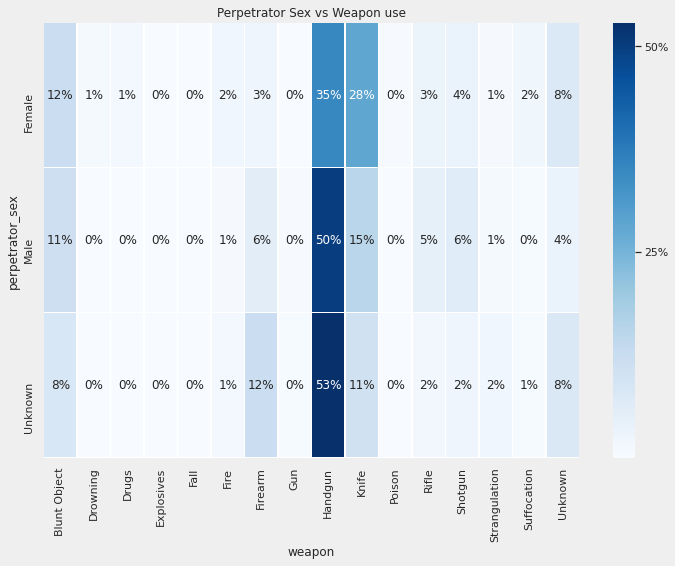

In [180]:
descriptionHeatmap(df1=df.perpetrator_sex, df2=df.weapon, titleName='Perpetrator Sex vs Weapon use')

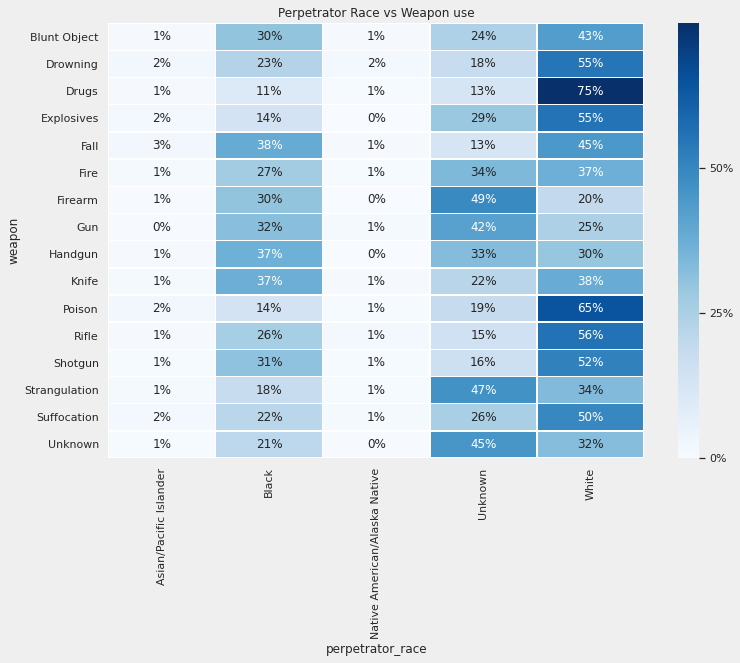

In [181]:
descriptionHeatmap(df1=df.weapon, df2=df.perpetrator_race, titleName='Perpetrator Race vs Weapon use')

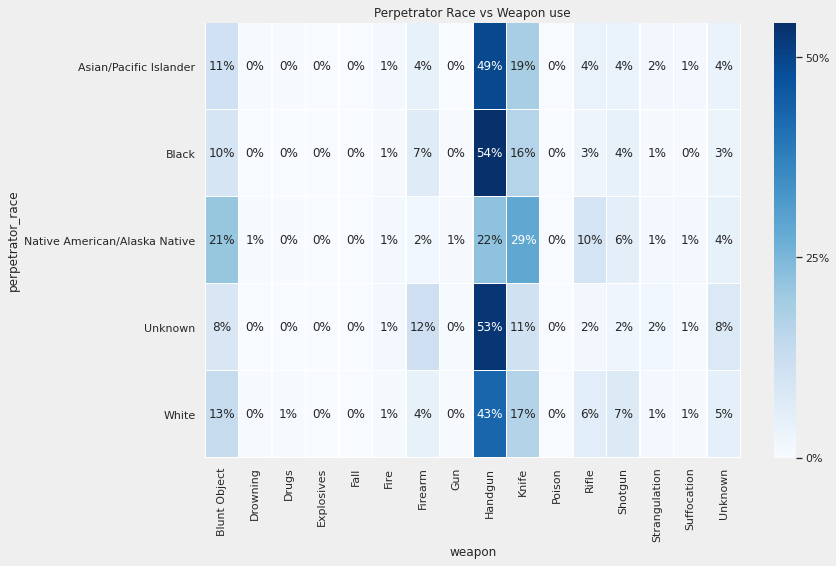

In [182]:
descriptionHeatmap(df1=df.perpetrator_race, df2=df.weapon, titleName='Perpetrator Race vs Weapon use')

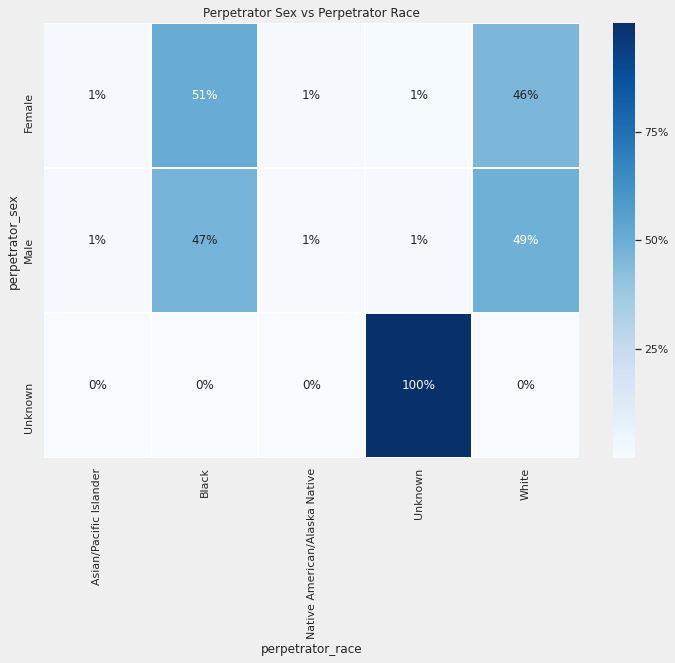

In [183]:
descriptionHeatmap(df1=df.perpetrator_sex, df2=df.perpetrator_race, titleName='Perpetrator Sex vs Perpetrator Race')

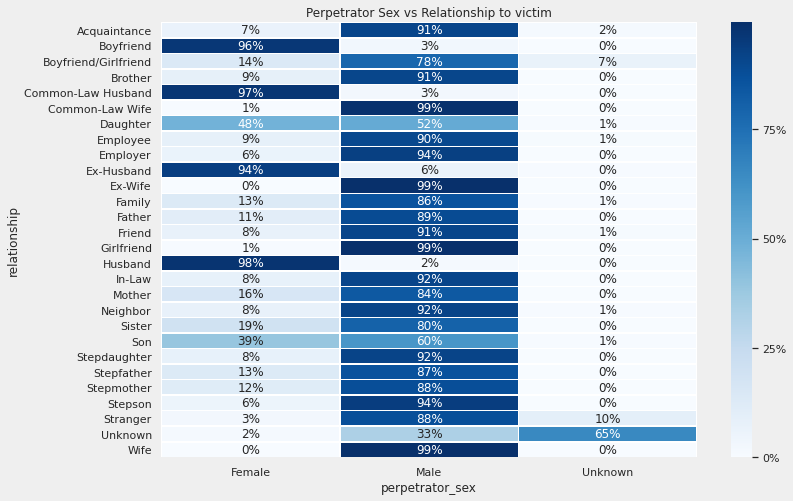

In [184]:
descriptionHeatmap(df1=df.relationship, df2=df.perpetrator_sex, titleName='Perpetrator Sex vs Relationship to victim')

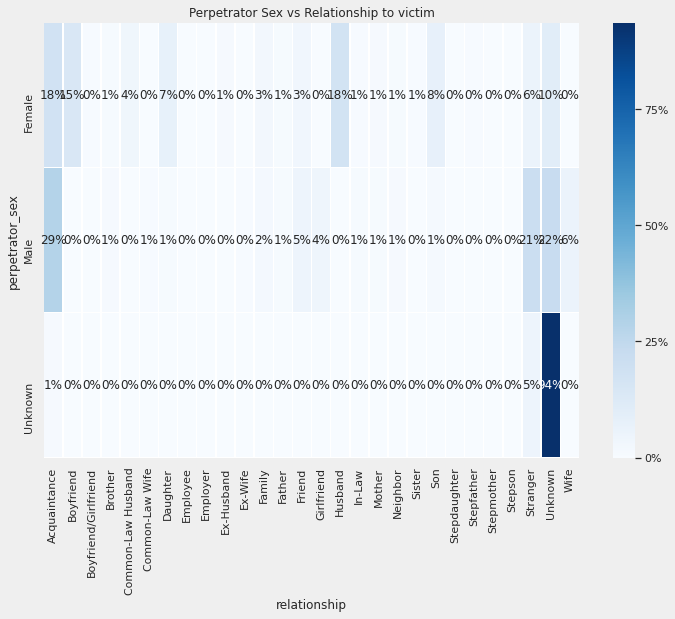

In [185]:
descriptionHeatmap(df1=df.perpetrator_sex, df2=df.relationship, titleName='Perpetrator Sex vs Relationship to victim')

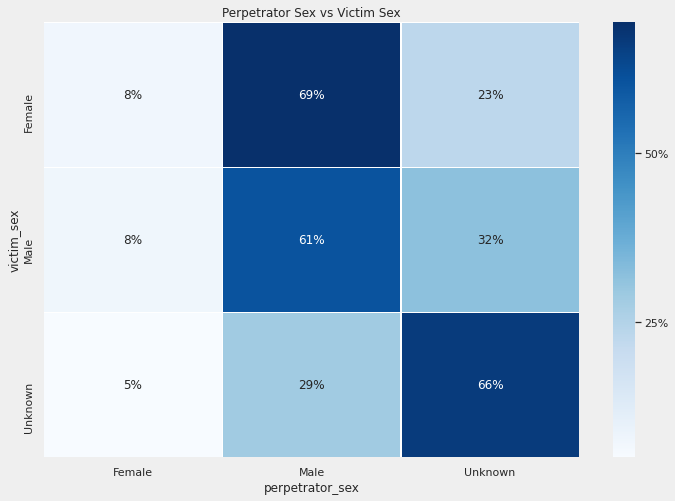

In [186]:
descriptionHeatmap(df1=df.victim_sex, df2=df.perpetrator_sex, titleName='Perpetrator Sex vs Victim Sex')

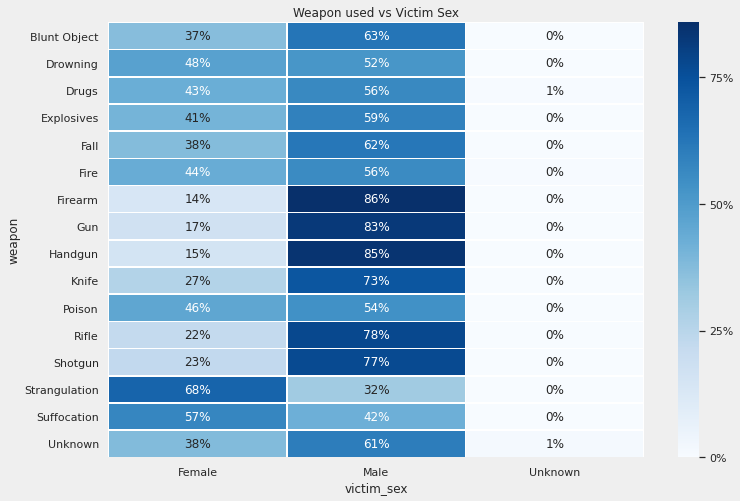

In [187]:
descriptionHeatmap(df1=df.weapon, df2=df.victim_sex, titleName='Weapon used vs Victim Sex')


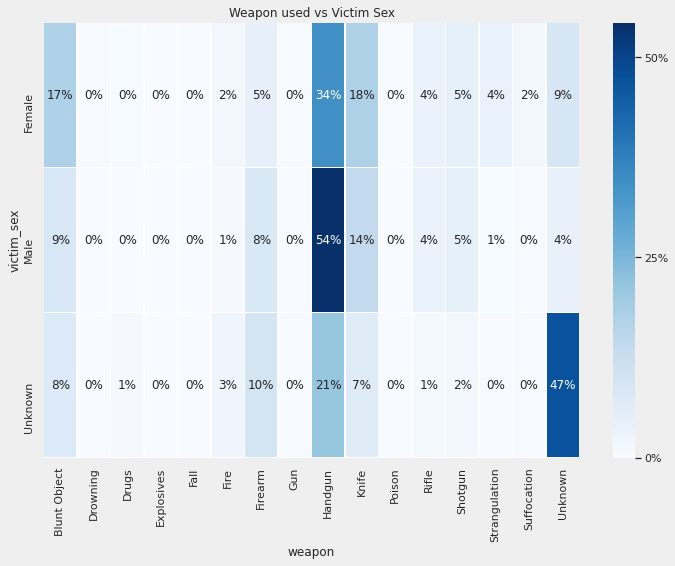

In [188]:
descriptionHeatmap(df1=df.victim_sex, df2=df.weapon, titleName='Weapon used vs Victim Sex')

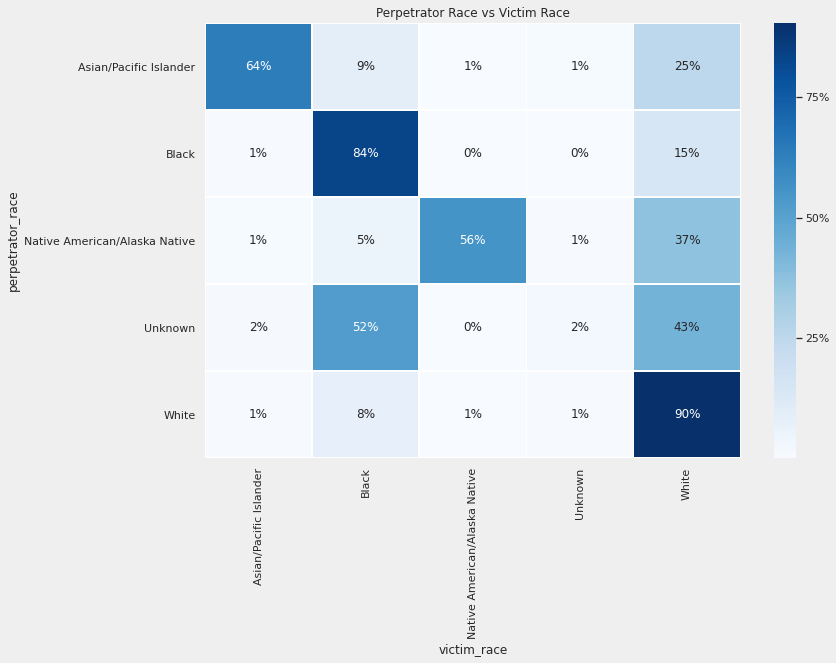

In [189]:
descriptionHeatmap(df1=df.perpetrator_race, df2=df.victim_race, titleName='Perpetrator Race vs Victim Race')

## Solved vs Unsolved

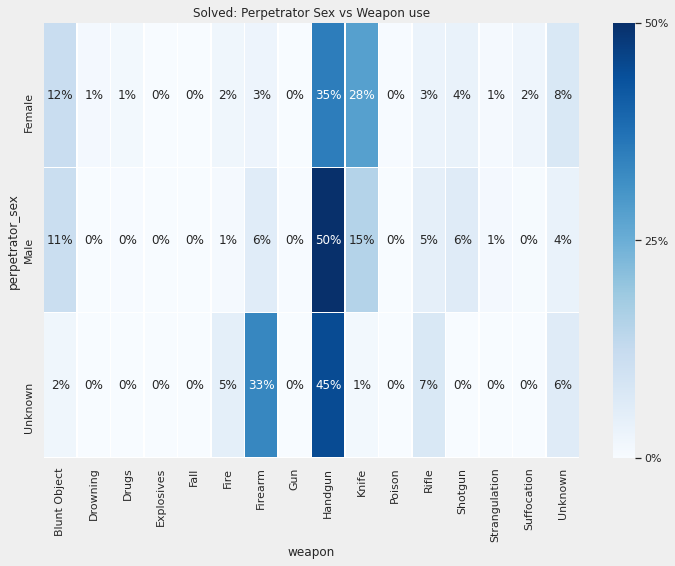

In [190]:
descriptionHeatmap(df1=df_solved.perpetrator_sex, df2=df_solved.weapon, titleName='Solved: Perpetrator Sex vs Weapon use')

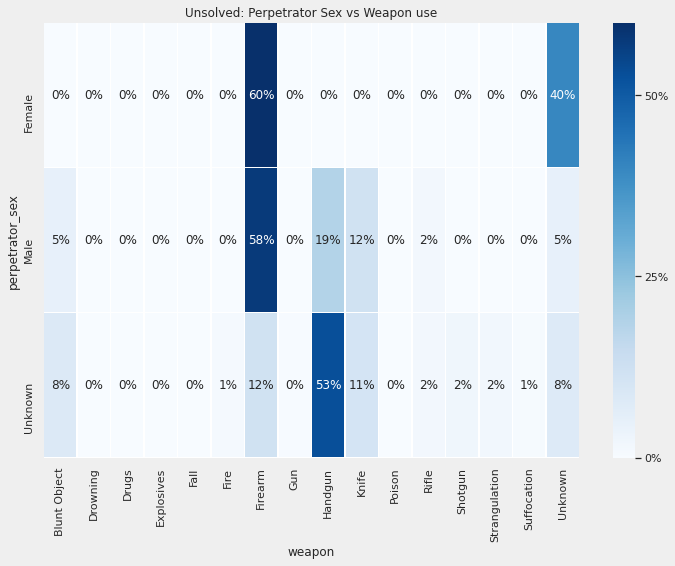

In [191]:
descriptionHeatmap(df1=df_unsolved.perpetrator_sex, df2=df_unsolved.weapon, titleName='Unsolved: Perpetrator Sex vs Weapon use')

In [192]:
sol_nativeRace = df_solved[df_solved['perpetrator_race']=='Native American/Alaska Native']
sol_whiteRace = df_solved[df_solved['perpetrator_race']=='White']
sol_unknownRace = df_solved[df_solved['perpetrator_race']=='Unknown']
sol_blackRace = df_solved[df_solved['perpetrator_race']=='Black']
sol_asianRace = df_solved[df_solved['perpetrator_race']=='Asian/Pacific Islander']

unsol_nativeRace = df_unsolved[df_unsolved['perpetrator_race']=='Native American/Alaska Native']
unsol_whiteRace = df_unsolved[df_unsolved['perpetrator_race']=='White']
unsol_unknownRace = df_unsolved[df_unsolved['perpetrator_race']=='Unknown']
unsol_blackRace = df_unsolved[df_unsolved['perpetrator_race']=='Black']
unsol_asianRace = df_unsolved[df_unsolved['perpetrator_race']=='Asian/Pacific Islander']

In [193]:
sol_pct_wepons_native = sol_nativeRace.groupby(['weapon']).size() / sol_nativeRace['weapon'].count() * 100
sol_pct_wepons_white = sol_whiteRace.groupby(['weapon']).size() / sol_whiteRace['weapon'].count() * 100
sol_pct_wepons_unknown = sol_unknownRace.groupby(['weapon']).size() / sol_unknownRace['weapon'].count() * 100
sol_pct_wepons_black = sol_blackRace.groupby(['weapon']).size() / sol_blackRace['weapon'].count() * 100
sol_pct_wepons_asian = sol_asianRace.groupby(['weapon']).size() / sol_asianRace['weapon'].count() * 100

unsol_pct_wepons_native = unsol_nativeRace.groupby(['weapon']).size() / unsol_nativeRace['weapon'].count() * 100
unsol_pct_wepons_white = unsol_whiteRace.groupby(['weapon']).size() / unsol_whiteRace['weapon'].count() * 100
unsol_pct_wepons_unknown = unsol_unknownRace.groupby(['weapon']).size() / unsol_unknownRace['weapon'].count() * 100
unsol_pct_wepons_black = unsol_blackRace.groupby(['weapon']).size() / unsol_blackRace['weapon'].count() * 100
unsol_pct_wepons_asian = unsol_asianRace.groupby(['weapon']).size() / unsol_asianRace['weapon'].count() * 100

Text(0.5, 0, 'Weapons')

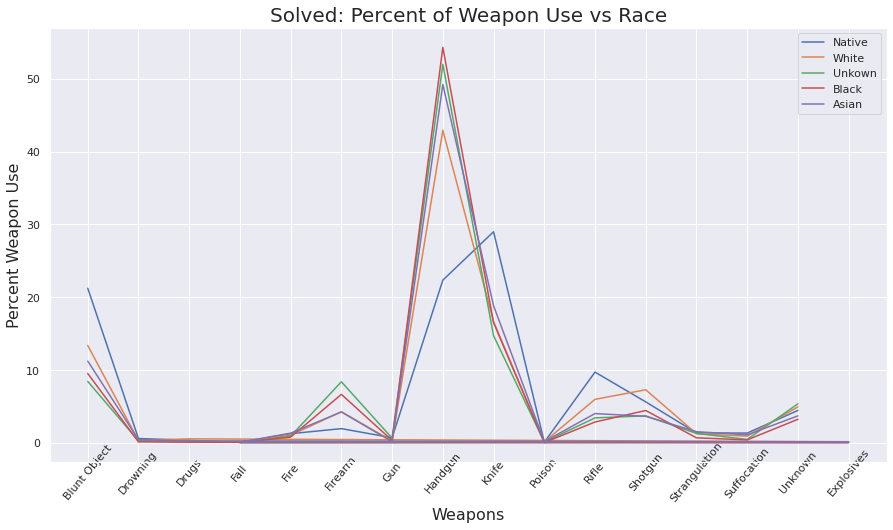

In [194]:
plt.figure(figsize=(15,8))
plt.plot(sol_pct_wepons_native.index, sol_pct_wepons_native, label='Native')
plt.plot(sol_pct_wepons_white.index, sol_pct_wepons_white, label= 'White')
plt.plot(sol_pct_wepons_unknown.index, sol_pct_wepons_unknown, label= 'Unkown')
plt.plot(sol_pct_wepons_black.index, sol_pct_wepons_black, label= 'Black')
plt.plot(sol_pct_wepons_asian.index, sol_pct_wepons_asian, label= 'Asian')
plt.xticks(rotation=50, verticalalignment = 'center')
plt.title('Solved: Percent of Weapon Use vs Race', fontsize=20)
plt.legend()
plt.ylabel('Percent Weapon Use', fontsize=16)
plt.xlabel('Weapons', fontsize=16)
# plt.grid()

In [195]:
# plt.figure(figsize=(15,8))
# plt.bar(unsol_pct_wepons_native.index, unsol_pct_wepons_native, label='Native')
# plt.bar(unsol_pct_wepons_white.index, unsol_pct_wepons_white, label= 'White')
# plt.bar(unsol_pct_wepons_unknown.index, unsol_pct_wepons_unknown, label= 'Unkown')
# plt.bar(unsol_pct_wepons_black.index, unsol_pct_wepons_black, label= 'Black')
# plt.bar(unsol_pct_wepons_asian.index, unsol_pct_wepons_asian, label= 'Asian')
# plt.xticks(rotation=50, verticalalignment = 'center_baseline')
# plt.title('Unsolved: Percent of Weapon Use vs Race', fontsize=20)
# plt.legend()
# plt.ylabel('Percent Weapon Use', fontsize=16)
# plt.xlabel('Weapons', fontsize=16)

Text(0.5, 0, 'Weapons')

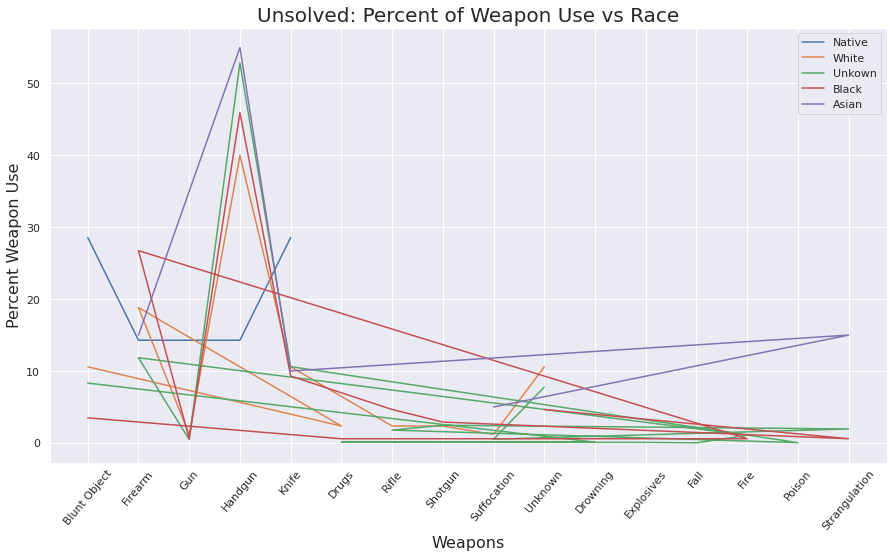

In [196]:
plt.figure(figsize=(15,8))
plt.plot(unsol_pct_wepons_native.index, unsol_pct_wepons_native, label='Native')
plt.plot(unsol_pct_wepons_white.index, unsol_pct_wepons_white, label= 'White')
plt.plot(unsol_pct_wepons_unknown.index, unsol_pct_wepons_unknown, label= 'Unkown')
plt.plot(unsol_pct_wepons_black.index, unsol_pct_wepons_black, label= 'Black')
plt.plot(unsol_pct_wepons_asian.index, unsol_pct_wepons_asian, label= 'Asian')
plt.xticks(rotation=50, verticalalignment = 'center_baseline')
plt.title('Unsolved: Percent of Weapon Use vs Race', fontsize=20)
plt.legend()
plt.ylabel('Percent Weapon Use', fontsize=16)
plt.xlabel('Weapons', fontsize=16)

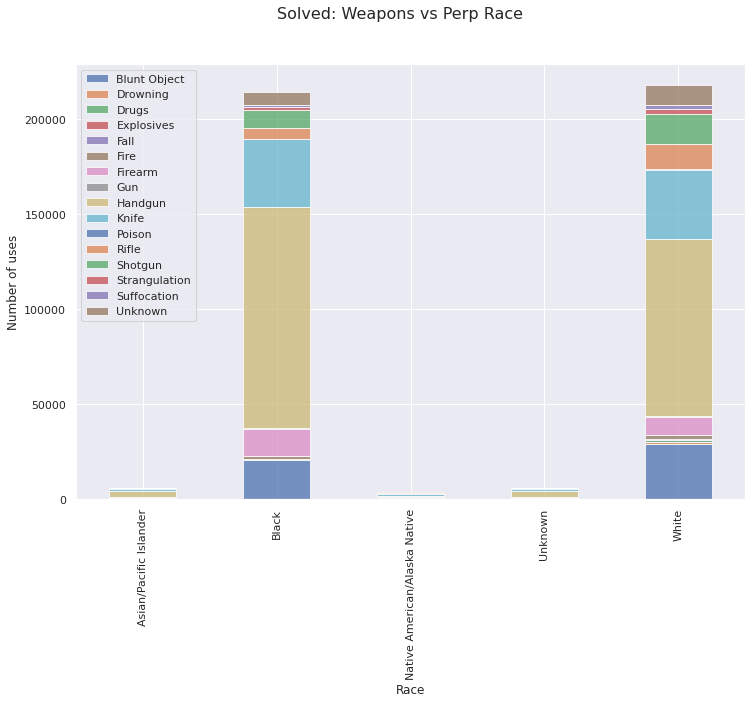

In [197]:
fig, ax = plt.subplots(figsize=(12,8))
df_solved.groupby(['perpetrator_race', 'weapon']).size().unstack().plot(ax=ax, stacked=True, kind='bar', alpha=0.75, legend=True)
fig.suptitle('Solved: Weapons vs Perp Race', fontsize=16)
plt.xlabel('Race', fontsize=12)
plt.ylabel('Number of uses', fontsize=12)
L=plt.legend()

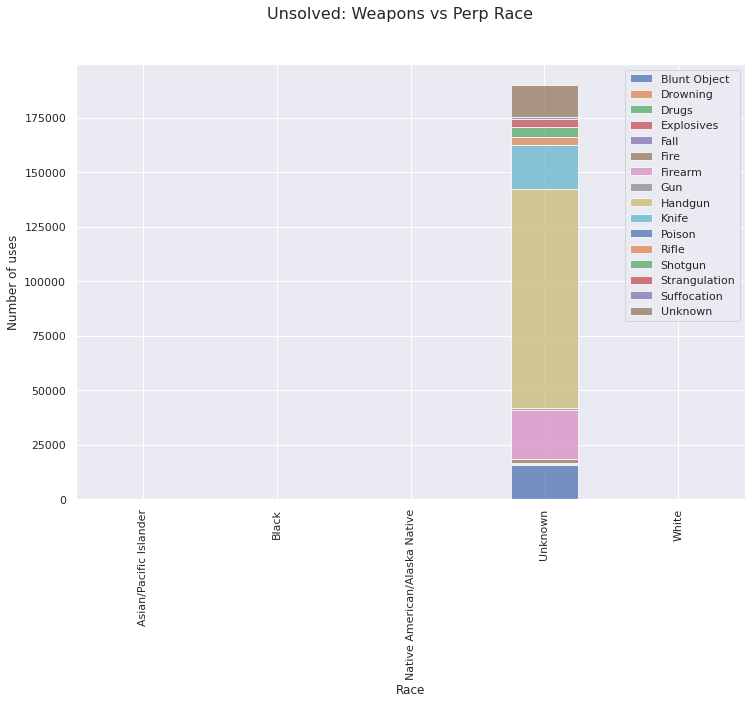

In [198]:
fig, ax = plt.subplots(figsize=(12,8))
df_unsolved.groupby(['perpetrator_race', 'weapon']).size().unstack().plot(ax=ax, stacked=True, kind='bar', alpha=0.75, legend=True)
fig.suptitle('Unsolved: Weapons vs Perp Race', fontsize=16)
plt.xlabel('Race', fontsize=12)
plt.ylabel('Number of uses', fontsize=12)
L=plt.legend()

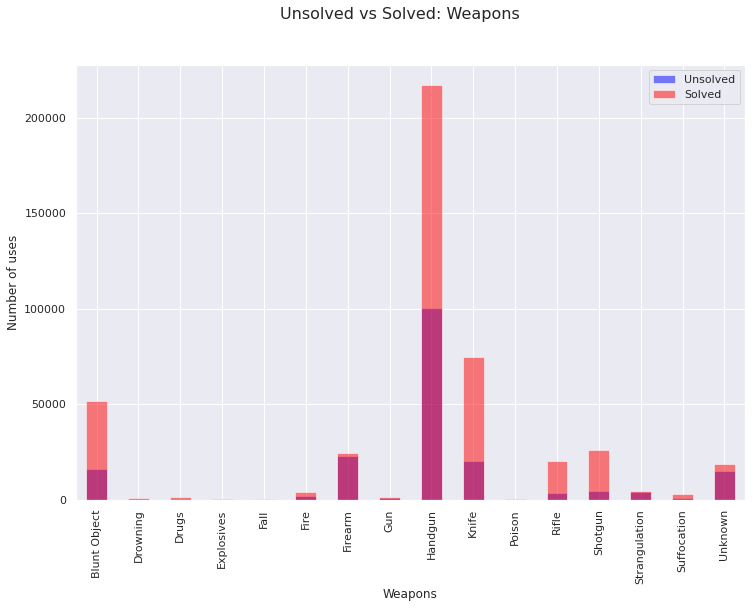

In [199]:
fig, ax = plt.subplots(figsize=(12,8))
df_unsolved.groupby(['weapon']).size().plot(ax=ax, kind='bar', alpha=0.5, legend=True, label='Unsolved', color='blue')
df_solved.groupby(['weapon']).size().plot(ax=ax, kind='bar', alpha=0.5, legend=True, label='Solved', color='red')
fig.suptitle('Unsolved vs Solved: Weapons', fontsize=16)
plt.xlabel('Weapons', fontsize=12)
plt.ylabel('Number of uses', fontsize=12)
L=plt.legend()

In [200]:
df_solved['perpetrator_sex'].value_counts()

Male       399482
Female      48543
Unknown       147
Name: perpetrator_sex, dtype: int64

In [201]:
df_unsolved['perpetrator_sex'].value_counts()

Unknown    190218
Male           59
Female          5
Name: perpetrator_sex, dtype: int64

In [202]:
df_unsolved.groupby(['relationship', 'perpetrator_sex']).size()

relationship          perpetrator_sex
Acquaintance          Unknown              2166
Boyfriend             Unknown                14
Boyfriend/Girlfriend  Unknown               102
Brother               Unknown                18
Common-Law Husband    Unknown                 7
Common-Law Wife       Unknown                 7
Daughter              Unknown                52
Employee              Unknown                 4
Ex-Husband            Unknown                 3
Ex-Wife               Unknown                 7
Family                Unknown                68
Father                Unknown                 8
Friend                Unknown               227
Girlfriend            Unknown                52
Husband               Female                  1
                      Unknown                25
In-Law                Unknown                 9
Mother                Unknown                10
Neighbor              Unknown                36
Sister                Unknown                 4
So

In [203]:
# df_solved.groupby(['relationship', 'perpetrator_sex']).size()

In [204]:
# sol_women_only = df_solved[df_solved['perpetrator_sex']=='Female']
# sol_men_only = df_solved[df_solved['perpetrator_sex']=='Male']
# sol_unknown_only = df_solved[df_solved['perpetrator_sex']=='Unknown']

# unsol_women_only = df_unsolved[df_unsolved['perpetrator_sex']=='Female']
# unsol_men_only = df_unsolved[df_unsolved['perpetrator_sex']=='Male']
# unsol_unknown_only = df_unsolved[df_unsolved['perpetrator_sex']=='Unknown']

# Trying out models

## Decision Tree Model

###Preparing Data

First we must encode the catagorical data to be of the numeric type

In [ ]:
df.head(1)

,state,city,total_homicides,lat,lng,population,record_id,agency_code,agency_name,agency_type,year,month,incident,crime_type,crime_solved,victim_sex,victim_age,victim_race,victim_ethnicity,perpetrator_sex,perpetrator_age,perpetrator_race,perpetrator_ethnicity,relationship,weapon,victim_count,perpetrator_count,record_source,same_race,same_sex,month_number,date,solved,unsolved,victim_age_group,perpetrator_age_group,same_age,weapon_gun
0,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,1,AK00101,Anchorage,Municipal Police,1980,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI,1.0,1.0,1,1980-01-01,1,0,teenager,teenager,1.0,0.0


We drop all columns that contain information about the perpetrator, and unique identifiers

In [ ]:
df_encoded_dt = df.drop(['record_id', 'agency_code', 'month','incident','crime_solved','perpetrator_sex','perpetrator_age','perpetrator_race','perpetrator_ethnicity', 'record_source','perpetrator_age_group','unsolved', 'perpetrator_count',	'same_race',	'same_sex','same_age','relationship'], axis = 1)

In [ ]:
df_encoded_dt.head(1)

,state,city,total_homicides,lat,lng,population,agency_name,agency_type,year,crime_type,victim_sex,victim_age,victim_race,victim_ethnicity,weapon,victim_count,month_number,date,solved,victim_age_group,weapon_gun
0,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,Anchorage,Municipal Police,1980,Murder or Manslaughter,Male,14,Native American/Alaska Native,Unknown,Blunt Object,0,1,1980-01-01,1,teenager,0.0


In [ ]:
def encodeColumn(data, column):
  le = LabelEncoder()
  data[column] = le.fit_transform(data[column])

In [ ]:
encodeColumn(df_encoded_dt, 'agency_name')
encodeColumn(df_encoded_dt, 'agency_type')
encodeColumn(df_encoded_dt, 'city')
encodeColumn(df_encoded_dt, 'state')
encodeColumn(df_encoded_dt, 'crime_type')
encodeColumn(df_encoded_dt, 'victim_sex')
encodeColumn(df_encoded_dt, 'victim_race')
encodeColumn(df_encoded_dt, 'victim_ethnicity')
age_group_dict = {'unknown':0,'child':1,'teenager':2,'young adult':3,'adult':4,'elder':5}
df_encoded_dt['victim_age_group'] = df_encoded_dt['victim_age_group'].map(age_group_dict)

Expanding `weapon` to indicate 1 or 0 for each weapon

In [ ]:
df_encoded_dt['weapon'].unique()

array(['Blunt Object', 'Strangulation', 'Unknown', 'Rifle', 'Knife',
       'Firearm', 'Shotgun', 'Fall', 'Handgun', 'Fire', 'Drugs',
       'Explosives', 'Drowning', 'Gun', 'Suffocation', 'Poison'],
      dtype=object)

In [ ]:
def expandColumn(columnName, desiredValue, newColumn):
  df_encoded_dt.loc[(df_encoded_dt[columnName]== desiredValue), desiredValue] = 1
  df_encoded_dt[desiredValue] = df_encoded_dt[desiredValue].fillna(0)

In [ ]:
for weapon in df_encoded_dt['weapon'].unique():
  expandColumn('weapon', weapon, weapon)

In [ ]:
df_encoded_dt.head()

,state,city,total_homicides,lat,lng,population,agency_name,agency_type,year,crime_type,victim_sex,victim_age,victim_race,victim_ethnicity,weapon,victim_count,month_number,date,solved,victim_age_group,weapon_gun,Blunt Object,Strangulation,Unknown,Rifle,Knife,Firearm,Shotgun,Fall,Handgun,Fire,Drugs,Explosives,Drowning,Gun,Suffocation,Poison
0,1,35,676,61.1508,-149.1091,253421.0,149,1,1980,1,1,14,2,2,Blunt Object,0,1,1980-01-01,1,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,35,676,61.1508,-149.1091,253421.0,149,1,1980,1,1,43,4,2,Strangulation,0,3,1980-03-01,1,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,35,676,61.1508,-149.1091,253421.0,149,1,1980,1,0,30,2,2,Unknown,0,3,1980-03-01,0,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,35,676,61.1508,-149.1091,253421.0,149,1,1980,1,1,43,4,2,Strangulation,0,4,1980-04-01,1,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,35,676,61.1508,-149.1091,253421.0,149,1,1980,1,0,30,2,2,Unknown,0,4,1980-04-01,0,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating Decision Tree Model

In [ ]:
train_df, test_df = train_test_split(df_encoded_dt, test_size=0.4, stratify=df_encoded_dt['solved'])

In [ ]:
train_df['solved'].value_counts(normalize=True)

1    0.701965
0    0.298035
Name: solved, dtype: float64

In [ ]:
y_col = 'solved'

X_cols = ['total_homicides','weapon_gun','agency_name',	'agency_type',	'city',	'state',	'year',	'crime_type',	'victim_sex',	'victim_age',	'victim_race',	'victim_ethnicity',	'victim_count',	'lat',	'lng',	'population',	'month_number',	'victim_age_group', 'Blunt Object',	'Strangulation',	'Unknown',	'Rifle',	'Knife',	'Firearm',	'Shotgun',	'Fall','Handgun',	'Fire',	'Drugs',	'Explosives',	'Drowning',	'Gun',	'Suffocation',	'Poison']

X_train = train_df[X_cols]
X_test = test_df[X_cols]

y_train = train_df[y_col]
y_test = test_df[y_col]

In [ ]:
X_train.head()

,total_homicides,weapon_gun,agency_name,agency_type,city,state,year,crime_type,victim_sex,victim_age,victim_race,victim_ethnicity,victim_count,lat,lng,population,month_number,victim_age_group,Blunt Object,Strangulation,Unknown,Rifle,Knife,Firearm,Shotgun,Fall,Handgun,Fire,Drugs,Explosives,Drowning,Gun,Suffocation,Poison
52451,44511,1.0,4351,1,946,4,1981,1,1,31,4,0,0,34.1139,-118.4068,12815475.0,12,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135290,2365,0.0,1922,1,461,5,1983,1,1,68,4,1,0,39.7621,-104.8759,2787266.0,7,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
630274,12,1.0,1118,3,259,25,1995,1,1,19,4,2,0,0.0000,0.0000,833671.0,8,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
219277,22338,1.0,1318,1,384,13,1993,0,0,17,1,2,0,0.0000,0.0000,833671.0,9,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182780,1559,0.0,7216,1,1253,9,2006,1,1,83,4,2,0,0.0000,0.0000,833671.0,3,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The initial parameters we used were a max_depth of 20. Where this means the tree can not have a depth of more than 20 levels. We also set min_samples_split to be 5. Thus we can not have a leaf/internal node split with less than 5 data points. This was used to help prevent the model from overfitting the data. Finally we let min_samples_leaf to be 5. Where this is the minimum number of samples required to be at a leaf node. This was also chosen to prevent overfitting. 

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=20, min_samples_split=5, min_samples_leaf=5)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

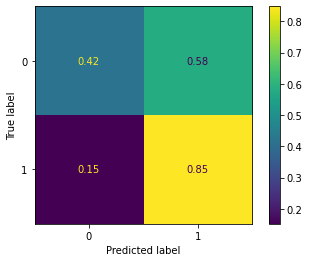

In [ ]:
plot_confusion_matrix(dt_clf, X_test, y_test, normalize='true')

The initial decision tree model we created is performing best in predicting cases that were solved. We see that a case that was actually solved was predicted correctly 84% of the time. And cases that were not actually solved were only predicted correctly 43% of the time. 

In [ ]:
dt_clf.feature_importances_

array([1.84127630e-01, 9.69979859e-03, 7.96841784e-02, 1.29909499e-02,
       3.34364826e-02, 6.98096981e-02, 1.37383426e-01, 6.86592968e-03,
       2.10912537e-02, 1.43975364e-01, 2.33024656e-02, 1.95840863e-02,
       1.43489406e-02, 7.88161870e-03, 2.49439456e-02, 1.00914185e-02,
       7.79764740e-02, 4.75558836e-03, 7.13154787e-03, 7.05101686e-03,
       2.67604303e-02, 2.89097519e-03, 1.80740968e-02, 3.98683074e-02,
       1.82987067e-03, 6.03234188e-05, 9.24613826e-03, 2.25363744e-03,
       3.35358252e-04, 0.00000000e+00, 1.07148274e-04, 1.83044371e-03,
       6.11456639e-04, 0.00000000e+00])

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33],
 <a list of 34 Text major ticklabel objects>)

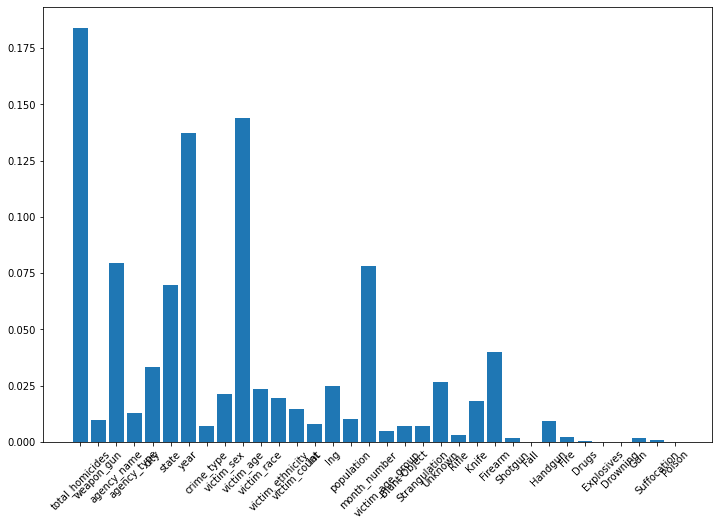

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(X_test.columns, dt_clf.feature_importances_)
plt.xticks(rotation = 45)

Looking at the plot of feature importance we see the model is using `total_homicides` as its most important feature. As a reminder this column is the total of how many homicides occured within a specific city. The column `victim_age` is also of great importance, however not the `victim_age_group` column we created. It is also using the column `year`.

###Hyper Parameter Tuning

We will now try to increase the accuracy of our decision tree model by hyper parameter tuning. 



In [ ]:
hyperparam_grid = {'min_samples_split': [2, 10, 25, 50, 100],
                  'max_depth': [3, 10, 25, 50],
                  'min_samples_leaf': [2, 10, 50, 100]}

Next, we instantiate grid search just like we did for the original model. This will return the model with the hyperparameters that gave the best result.

In [ ]:
dt_clf = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_clf, hyperparam_grid, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 10, 25, 50],
                      

In [ ]:
grid_search.best_params_

{'max_depth': 50, 'min_samples_leaf': 100, 'min_samples_split': 10}

After hyper parameter tuning we found that the parameters that yielded the highest overall accurate model were: `(max_depth=50, min_samples_split=100, min_samples_leaf=10)`

In [ ]:
dt_clf_best = DecisionTreeClassifier(max_depth=50, min_samples_split=100, min_samples_leaf=10)

dt_clf_best.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

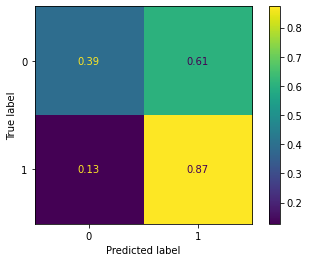

In [ ]:
plot_confusion_matrix(dt_clf_best, X_test, y_test, normalize='true')
plt.savefig(graph_folder + 'graphs/confusion.png', format = 'png', transparent=False)

Our newly trained model does now preform better in predicting solved cases, however its accuracy has decreased by 2% when predicting unsolved cases. 

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33],
 <a list of 34 Text major ticklabel objects>)

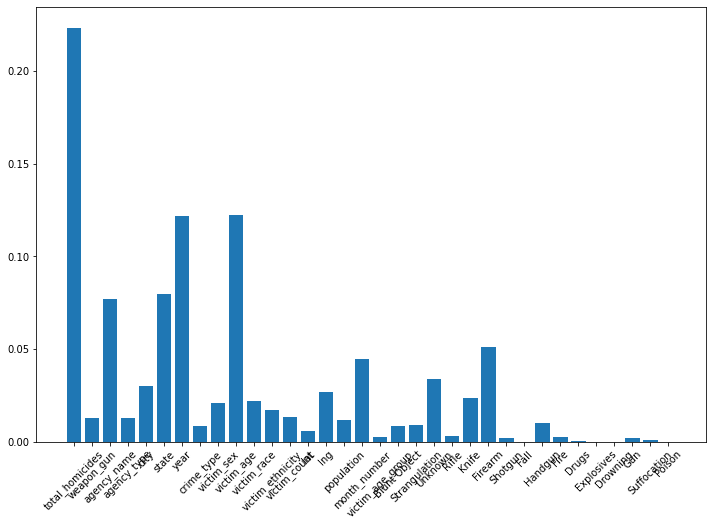

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(X_test.columns, dt_clf_best.feature_importances_)
plt.xticks(rotation = 45)

The model still uses `total_homicides`,`year` and `victim_age` as important features.

In [ ]:
dt_clf_best_pred = dt_clf_best.predict(X_test)
print(dt_clf_best_pred)

[1 1 1 ... 1 1 1]


In [ ]:
X_test.head()

,total_homicides,weapon_gun,agency_name,agency_type,city,state,year,crime_type,victim_sex,victim_age,victim_race,victim_ethnicity,victim_count,lat,lng,population,month_number,victim_age_group,Blunt Object,Strangulation,Unknown,Rifle,Knife,Firearm,Shotgun,Fall,Handgun,Fire,Drugs,Explosives,Drowning,Gun,Suffocation,Poison
19059,156,0.0,1478,3,354,2,1997,1,0,35,4,1,0,0.0000,0.0000,833671.0,6,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
357202,510,0.0,2770,1,603,33,1982,1,1,2,1,1,0,0.0000,0.0000,833671.0,6,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464478,2788,0.0,5539,1,1170,36,1982,1,0,37,4,1,0,0.0000,0.0000,833671.0,9,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136784,2365,0.0,1922,1,461,5,2003,1,0,25,1,2,0,39.7621,-104.8759,2787266.0,11,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315150,19038,1.0,1987,1,1695,22,1992,1,1,22,1,2,0,42.2774,-83.3877,16947.0,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_test.head()

19059     0
357202    1
464478    1
136784    1
315150    1
Name: solved, dtype: int64

## XG Boost

### Encoding the data

In [675]:
df_encoded=df.drop(['record_id','crime_type','agency_code','agency_name','date','victim_ethnicity','perpetrator_ethnicity','record_source','solved','crime_solved','perpetrator_age','victim_age','lat','lng','perpetrator_sex','perpetrator_race','same_race','same_sex','perpetrator_count','perpetrator_age_group','same_age','relationship','incident'], axis = 1)

In [676]:
age_group_dict = {'unknown':0,'child':1,'teenager':2,'young adult':3,'adult':4,'elder':5}
df_encoded['victim_age_group'] = df_encoded['victim_age_group'].map(age_group_dict)

In [677]:
for c in df_encoded.columns:
  if c != 'unsolved':  
    if df_encoded[c].dtype == object:  #If it is a string, then encode it. 
        try:  
            le = LabelEncoder()           
            le.fit(df_encoded[c].unique())    
            df_encoded[c] = le.transform(df_encoded[c])  
        except Exception as e:         
            print(c)         
            print(e)

### Oversampling

As you can see, the amount of unsolved homicides is a small percentage of our total dataset.

In [678]:
df_encoded['unsolved'].value_counts()

0    448172
1    190282
Name: unsolved, dtype: int64

To fix this, let's do oversampling where we duplicate the unsolved data.

In [679]:
def oversample(df, column, value):
  train_1_df = df[df[column] == 1]
  train_1_df = train_1_df.sample(value, replace=True)  #This duplicates the rows that are unsolved


  train_0_df = df[df[column] == 0]

  df = pd.concat([train_0_df, train_1_df])

  return df_encoded_over

In [680]:
df_encoded_over = oversample(df_encoded, 'unsolved', 448172)

In [681]:
df_encoded_over['unsolved'].value_counts()

0    448172
1    190282
Name: unsolved, dtype: int64

Below you can see we now have around 600,000 data points to train and test with.

In [682]:
df_encoded_over.shape

(638454, 16)

In [683]:
from sklearn.model_selection import train_test_split
y = df_encoded_over.unsolved  #We just want the unsolved here
X = df_encoded_over.drop(['unsolved'], axis=1)  #Every column except the unsolved
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=123)

### Running the model

Now we can do XGBoost.

In [684]:
model2 = xgb.XGBClassifier()
model2.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [685]:
from sklearn.metrics import accuracy_score
pred2 = model2.predict(test_X)
print("Accuracy for model: %.2f" % (accuracy_score(test_y, pred2) * 100))

Accuracy for model: 72.65


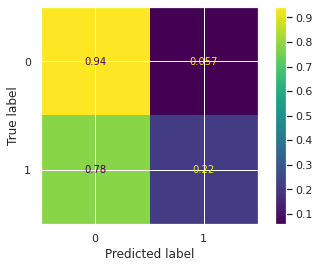

In [686]:
plot_confusion_matrix(model2, test_X, test_y, normalize='true')

In [687]:
featuredf = pd.DataFrame(model2.feature_importances_, train_X.columns)

In [688]:
featuredf = featuredf.sort_values(by=0, ascending=False)
featuredf[0] = featuredf[0]*100
featuredf = featuredf[:10]

In [689]:
from matplotlib import pyplot as plt

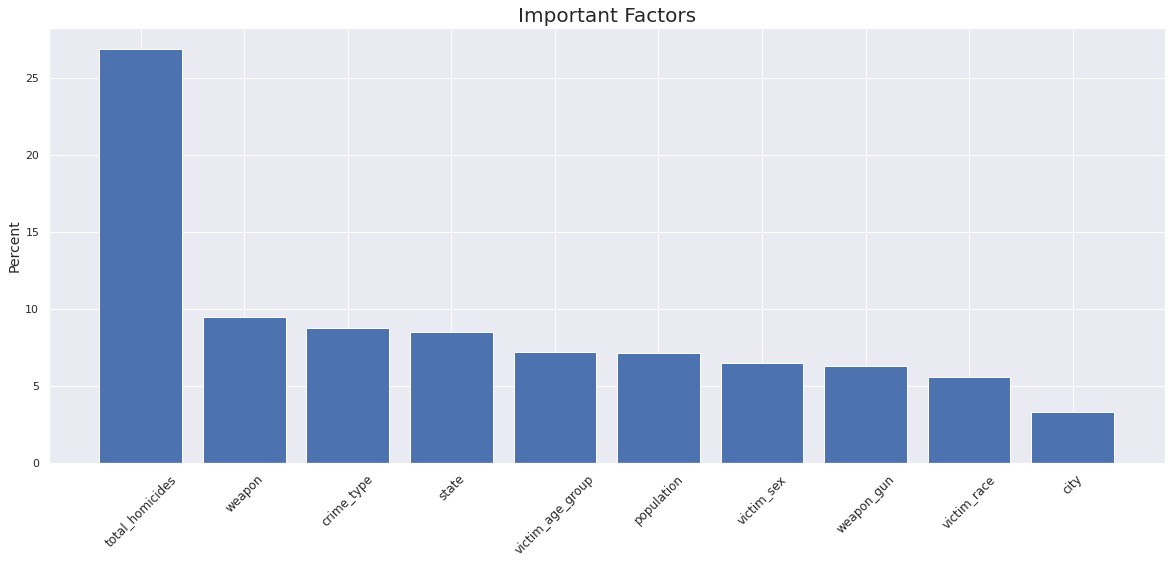

In [690]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.title('Important Factors', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);

### Undersampling 

In [701]:
df_encoded['unsolved'].value_counts()

0    448172
1    190282
Name: unsolved, dtype: int64

In [702]:
train_df, test_df = train_test_split(df_encoded, test_size=0.4, stratify=df_encoded['unsolved'])

In [703]:
train_solved_df = train_df[train_df['unsolved'] == 0]
train_solved_df = train_solved_df.sample(190282)

train_unsolved_df = train_df[train_df['unsolved'] == 1]

train_under_df = pd.concat([train_unsolved_df, train_solved_df])

In [704]:
y = train_under_df.unsolved  #We just want the unsolved here
X = train_under_df.drop(['unsolved'], axis=1)  #Every column except the unsolved
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=123)

In [705]:
under_model = xgb.XGBClassifier()
under_model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [706]:
pred_under = under_model.predict(test_X)
print("Accuracy for model: %.2f" % (accuracy_score(test_y, pred_under) * 100))

Accuracy for model: 69.31


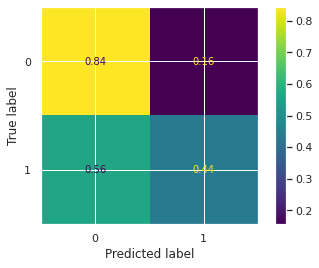

In [707]:
plot_confusion_matrix(under_model, test_X, test_y, normalize='true')
plt.savefig(graph_folder + 'graphs/xg_confusion.png', format = 'png', transparent=False)

In [708]:
featuredf_under = pd.DataFrame(under_model.feature_importances_, train_X.columns)

In [709]:
featuredf_under = featuredf_under.sort_values(by=0, ascending=False)
featuredf_under[0] = featuredf_under[0]*100
featuredf_under = featuredf_under[:10]

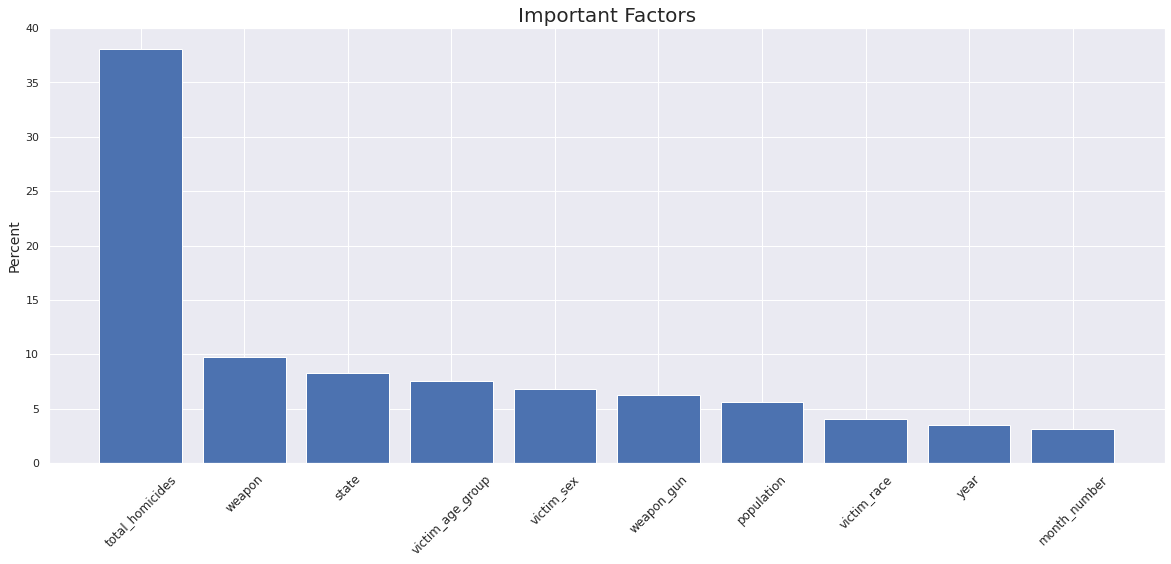

In [710]:
plt.figure(figsize=(20, 8))

x = featuredf_under.index
y = featuredf_under[0]

plt.title('Important Factors', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);
plt.savefig(graph_folder + 'graphs/xg_importfeat.png', format = 'png', transparent=False)

## KNN Model

#### Cleaning and encoding the data to use

In [ ]:
df.head()

,state,city,total_homicides,lat,lng,population,record_id,agency_code,agency_name,agency_type,year,month,incident,crime_type,crime_solved,victim_sex,victim_age,victim_race,victim_ethnicity,perpetrator_sex,perpetrator_age,perpetrator_race,perpetrator_ethnicity,relationship,weapon,victim_count,perpetrator_count,record_source,same_race,same_sex,month_number,date,solved,unsolved,victim_age_group,perpetrator_age_group,same_age,weapon_gun
0,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,1,AK00101,Anchorage,Municipal Police,1980,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI,1.0,1.0,1,1980-01-01,1,0,teenager,teenager,1.0,0.0
1,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,2,AK00101,Anchorage,Municipal Police,1980,March,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,1.0,1.0,3,1980-03-01,1,0,adult,adult,1.0,0.0
2,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,3,AK00101,Anchorage,Municipal Police,1980,March,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI,0.0,0.0,3,1980-03-01,0,1,adult,unknown,0.0,0.0
3,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,4,AK00101,Anchorage,Municipal Police,1980,April,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,1.0,1.0,4,1980-04-01,1,0,adult,adult,1.0,0.0
4,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,5,AK00101,Anchorage,Municipal Police,1980,April,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI,0.0,0.0,4,1980-04-01,0,1,adult,unknown,0.0,0.0


In [ ]:
encode_df = df.drop(['record_id', 'agency_code', 'month','incident','crime_solved','perpetrator_sex','perpetrator_age','perpetrator_race',
                     'perpetrator_ethnicity', 'record_source','perpetrator_age_group','unsolved'], axis = 1)

In [ ]:
encode_df.head(3)

,state,city,total_homicides,lat,lng,population,agency_name,agency_type,year,crime_type,victim_sex,victim_age,victim_race,victim_ethnicity,relationship,weapon,victim_count,perpetrator_count,same_race,same_sex,month_number,date,solved,victim_age_group,same_age,weapon_gun
0,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,Anchorage,Municipal Police,1980,Murder or Manslaughter,Male,14,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,1.0,1.0,1,1980-01-01,1,teenager,1.0,0.0
1,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,Anchorage,Municipal Police,1980,Murder or Manslaughter,Male,43,White,Unknown,Acquaintance,Strangulation,0,0,1.0,1.0,3,1980-03-01,1,adult,1.0,0.0
2,Alaska,Anchorage,676,61.1508,-149.1091,253421.0,Anchorage,Municipal Police,1980,Murder or Manslaughter,Female,30,Native American/Alaska Native,Unknown,Unknown,Unknown,0,0,0.0,0.0,3,1980-03-01,0,adult,0.0,0.0


In [ ]:
encode_df.columns

Index(['state', 'city', 'total_homicides', 'lat', 'lng', 'population',
       'agency_name', 'agency_type', 'year', 'crime_type', 'victim_sex',
       'victim_age', 'victim_race', 'victim_ethnicity', 'relationship',
       'weapon', 'victim_count', 'perpetrator_count', 'same_race', 'same_sex',
       'month_number', 'date', 'solved', 'victim_age_group', 'same_age',
       'weapon_gun'],
      dtype='object')

In [ ]:
encode_df.dtypes

state                        object
city                         object
total_homicides               int64
lat                         float64
lng                         float64
population                  float64
agency_name                  object
agency_type                  object
year                          int64
crime_type                   object
victim_sex                   object
victim_age                    int64
victim_race                  object
victim_ethnicity             object
relationship                 object
weapon                       object
victim_count                  int64
perpetrator_count             int64
same_race                   float64
same_sex                    float64
month_number                  int64
date                 datetime64[ns]
solved                        int64
victim_age_group             object
same_age                    float64
weapon_gun                  float64
dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder, normalize

In [ ]:
label_encoders = {}
for c in encode_df:
  if encode_df[c].dtype == 'object':
    le = LabelEncoder()
    encode_df[c] = le.fit_transform(encode_df[c])
    label_encoders[c] = le

encode_df.head()

,state,city,total_homicides,lat,lng,population,agency_name,agency_type,year,crime_type,victim_sex,victim_age,victim_race,victim_ethnicity,relationship,weapon,victim_count,perpetrator_count,same_race,same_sex,month_number,date,solved,victim_age_group,same_age,weapon_gun
0,1,35,676,61.1508,-149.1091,253421.0,149,1,1980,1,1,14,2,2,0,0,0,0,1.0,1.0,1,1980-01-01,1,3,1.0,0.0
1,1,35,676,61.1508,-149.1091,253421.0,149,1,1980,1,1,43,4,2,0,13,0,0,1.0,1.0,3,1980-03-01,1,0,1.0,0.0
2,1,35,676,61.1508,-149.1091,253421.0,149,1,1980,1,0,30,2,2,26,15,0,0,0.0,0.0,3,1980-03-01,0,0,0.0,0.0
3,1,35,676,61.1508,-149.1091,253421.0,149,1,1980,1,1,43,4,2,0,13,0,0,1.0,1.0,4,1980-04-01,1,0,1.0,0.0
4,1,35,676,61.1508,-149.1091,253421.0,149,1,1980,1,0,30,2,2,26,15,0,1,0.0,0.0,4,1980-04-01,0,0,0.0,0.0


In [ ]:
encode_df['same_age'].fillna(0, inplace=True)

In [ ]:
encode_df['same_age'].unique()

array([1., 0.])

In [ ]:
encode_df['same_race'] = le.fit_transform(encode_df['same_race'])
encode_df['same_sex'] = le.fit_transform(encode_df['same_sex'])
encode_df['same_age'] = le.fit_transform(encode_df['same_age'])

In [ ]:
encode_df.dtypes

state                         int64
city                          int64
total_homicides               int64
lat                         float64
lng                         float64
population                  float64
agency_name                   int64
agency_type                   int64
year                          int64
crime_type                    int64
victim_sex                    int64
victim_age                    int64
victim_race                   int64
victim_ethnicity              int64
relationship                  int64
weapon                        int64
victim_count                  int64
perpetrator_count             int64
same_race                     int64
same_sex                      int64
month_number                  int64
date                 datetime64[ns]
solved                        int64
victim_age_group              int64
same_age                      int64
weapon_gun                  float64
dtype: object

#### Train, Test, Split

In [ ]:
train_df, test_df = train_test_split(encode_df, test_size=0.3, stratify=encode_df['solved'])

In [ ]:
print(f'Rows in original data: {encode_df.shape[0]}')
print(f'Rows in training data: {train_df.shape[0]} ({100*train_df.shape[0] / encode_df.shape[0]:.2f}%)')
print(f'Rows in testing data: {test_df.shape[0]} ({100*test_df.shape[0] / encode_df.shape[0]:.2f}%)')

Rows in original data: 638454
Rows in training data: 446917 (70.00%)
Rows in testing data: 191537 (30.00%)


In [ ]:
train_df['solved'].value_counts(normalize=True)

1    0.701965
0    0.298035
Name: solved, dtype: float64

In [ ]:
test_df['solved'].value_counts(normalize=True)

1    0.701964
0    0.298036
Name: solved, dtype: float64

#### KNN-classifier

In [ ]:
# for n_neighbors in [1, 5, 10, 15, 20]:
#     nn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, metric='hamming')

#     nn_clf.fit(X_mini, y_mini)

#     y_pred_nn = nn_clf.predict(X_test)

#     plot_confusion_matrix(nn_clf, X_test, y_test, normalize='true')
#     print(f'{n_neighbors} neighbors')
#     print(classification_report(y_test, y_pred_nn))
#     print('='*40)

#### Identifying feature importance 

In [ ]:


#Feature Matrix
X = encode_df.drop(['solved','date', 'same_race', 'same_sex', 'same_age', 'perpetrator_count', 'relationship'],1)  
#Target Variable
y = encode_df['solved']      

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### Further Analysis of KNN Model

In [ ]:
train_df, valid_df = train_test_split(train_df, test_size=int(0.1*encode_df.shape[0]))

In [ ]:
print(f'Rows in original data: {encode_df.shape[0]}')
print(f'Rows in training data: {train_df.shape[0]} ({100*train_df.shape[0] / encode_df.shape[0]:.2f}%)')
print(f'Rows in validation data: {valid_df.shape[0]} ({100*valid_df.shape[0] / encode_df.shape[0]:.2f}%)')
print(f'Rows in testing data: {test_df.shape[0]} ({100*test_df.shape[0] / encode_df.shape[0]:.2f}%)')

assert encode_df.shape[0] == train_df.shape[0] + valid_df.shape[0] + test_df.shape[0], "Data sizes don't match"

In [ ]:
def knn_model(df, n, train_df, test_df, valid_df):
  cols_to_use = ['agency_type', 'state', 'year',
       'victim_sex', 'victim_age', 'victim_race',
        'weapon', 'month_number',
       'victim_age_group']

  X_train = train_df[cols_to_use]
  y_train = train_df['solved']

  X_valid = valid_df[cols_to_use]
  y_valid = valid_df['solved']

  X_test = test_df[cols_to_use]
  y_test = test_df['solved']

  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)

  return knn, X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
# returns [maximum accuracy in range, the number of neighbors for that max accuracy]
def knn_max_acc(df, start, n, train_df, valid_df):

  acc_list = []
  cols_to_use = ['agency_type', 'state', 'year',
       'victim_sex', 'victim_age', 'victim_race',
        'weapon', 'month_number',
       'victim_age_group']

  max_neighbors = n

  X_train = train_df[cols_to_use]
  y_train = train_df['solved']

  X_valid = valid_df[cols_to_use]
  y_valid = valid_df['solved']


  for N in range(start, max_neighbors+1):
    knn = KNeighborsClassifier(n_neighbors=N)
    knn.fit(X_train, y_train)

    acc = knn.score(X_valid, y_valid)
    acc_list.append([acc,N])
  
  return max(acc_list)

In [ ]:
#Returns percent the model predicted correctly
# ex. correct predicted 1s / all actual 1s
def check_actual(knn, X, y, o):

  knn.predict(X)

  df = y.to_frame(name = 'actual')
  df['predicted'] = knn.predict(X)

  cut_check_df = df[df['actual'] == o]
  return (cut_check_df['actual'] == cut_check_df['predicted']).sum()/cut_check_df.shape[0]

In [ ]:
def check_pred(knn, X, y, o):

  knn.predict(X)

  df = y.to_frame(name = 'actual')
  df['predicted'] = knn.predict(X)

  cut_check_df = df[df['predicted'] == o]
  return (cut_check_df['actual'] == cut_check_df['predicted']).sum()/cut_check_df.shape[0]

In [ ]:
knn_max_acc(encode_df, 1, 60, train_df, valid_df)

In [ ]:
# training with the number of neighbors that give us the max accuracy
encoded_knn, Xknn_train, yknn_train, Xknn_valid, yknn_valid, Xknn_test, yknn_test = knn_model(encode_df,53,train_df,test_df,valid_df)

In [ ]:
check_actual(encoded_knn, Xknn_valid, yknn_valid, 0)

In [ ]:
check_actual(encoded_knn, Xknn_valid, yknn_valid, 1)

In [ ]:
check_pred(encoded_knn, Xknn_valid, yknn_valid, 0)

In [ ]:
check_pred(encoded_knn, Xknn_valid, yknn_valid, 1)

#### Confusion Matrix

In [ ]:
nn_clf = KNeighborsClassifier(n_neighbors=53, n_jobs=-1)

nn_clf.fit(Xknn_test, yknn_test)

y_pred_nn = nn_clf.predict(Xknn_test)

In [ ]:
plot_confusion_matrix(nn_clf, Xknn_test, yknn_test, normalize='true')

In [ ]:
print(classification_report(yknn_test, y_pred_nn))

#### Checking Hyperparameters

Note: ran for days so it was terminated

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn import metrics

In [ ]:
s# model = KNeighborsClassifier(n_jobs=-1)
# #Hyper Parameters Set
# params = {'n_neighbors':[1, 5, 10, 20],
#           'leaf_size':[1, 5, 10, 20],
#           'weights':['uniform', 'distance'],
#           'metric':['hamming', 'minkowski'],
#           'n_jobs':[-1]}
# #Making models with hyper parameters sets
# model1 = GridSearchCV(model, param_grid=params, n_jobs=1)
# #Learning
# model1.fit(X_train,y_train)

# print("Best Hyper Parameters:\n",model1.best_params_)
# #Prediction
# prediction=model1.predict(X_test)

# from sklearn import metrics
# #evaluation(Accuracy)
# print("Accuracy:",metrics.accuracy_score(prediction,y_test))
# #evaluation(Confusion Metrix)
# print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,y_test))

##### Taking away more columns to see if model improves

In [ ]:
def knn_model2(df, n, train_df, test_df, valid_df):
  cols_to_use = ['agency_type', 'state', 'year',
       'victim_sex', 'victim_age', 'victim_race',
        'weapon', 'month_number']

  X_train = train_df[cols_to_use]
  y_train = train_df['solved']

  X_valid = valid_df[cols_to_use]
  y_valid = valid_df['solved']

  X_test = test_df[cols_to_use]
  y_test = test_df['solved']

  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)

  return knn, X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
# returns [maximum accuracy in range, the number of neighbors for that max accuracy]
def knn_max_acc2(df, start, n, train_df, valid_df):

  acc_list = []
  cols_to_use = ['agency_type', 'state', 'year',
       'victim_sex', 'victim_age', 'victim_race',
        'weapon', 'month_number']

  max_neighbors = n

  X_train = train_df[cols_to_use]
  y_train = train_df['solved']

  X_valid = valid_df[cols_to_use]
  y_valid = valid_df['solved']


  for N in range(start, max_neighbors+1):
    knn = KNeighborsClassifier(n_neighbors=N)
    knn.fit(X_train, y_train)

    acc = knn.score(X_valid, y_valid)
    acc_list.append([acc,N])
  
  return max(acc_list)

In [ ]:
knn_max_acc2(encode_df, 1, 55, train_df, valid_df)

In [ ]:
encoded_knn2, Xknn2_train, yknn2_train, Xknn2_valid, yknn2_valid, Xknn2_test, yknn2_test = knn_model2(encode_df,55,train_df,test_df,valid_df)

In [ ]:
check_actual(encoded_knn2, Xknn2_valid, yknn2_valid, 0)

In [ ]:
check_actual(encoded_knn2, Xknn2_valid, yknn2_valid, 1)

In [ ]:
check_pred(encoded_knn2, Xknn2_valid, yknn2_valid, 0)

In [ ]:
check_pred(encoded_knn2, Xknn2_valid, yknn2_valid, 1)

In [ ]:
nn2_clf = KNeighborsClassifier(n_neighbors=55, n_jobs=-1)

nn2_clf.fit(Xknn2_test, yknn2_test)

y_pred_nn2 = nn2_clf.predict(Xknn2_test)

In [ ]:
plot_confusion_matrix(nn2_clf, Xknn2_test, yknn2_test, normalize='true')

In [ ]:
print(classification_report(yknn2_test, y_pred_nn2))

#### Second KNN model with 1 neighbor

In [ ]:
encoded_knn2, Xknn2_train, yknn2_train, Xknn2_valid, yknn2_valid, Xknn2_test, yknn2_test = knn_model2(encode_df,1,train_df,test_df,valid_df)

In [ ]:
check_actual(encoded_knn2, Xknn2_valid, yknn2_valid, 0)

In [ ]:
check_actual(encoded_knn2, Xknn2_valid, yknn2_valid, 1)

In [ ]:
check_pred(encoded_knn2, Xknn2_valid, yknn2_valid, 1)

In [ ]:
check_pred(encoded_knn2, Xknn2_valid, yknn2_valid, 0)

#### First KNN model with 1 neighbor

In [ ]:
encoded_knn, Xknn_train, yknn_train, Xknn_valid, yknn_valid, Xknn_test, yknn_test = knn_model(encode_df,1,train_df,test_df,valid_df)

In [ ]:
check_actual(encoded_knn, Xknn_valid, yknn_valid, 0)

In [ ]:
check_actual(encoded_knn, Xknn_valid, yknn_valid, 1)

In [ ]:
check_pred(encoded_knn, Xknn_valid, yknn_valid, 0)

In [ ]:
check_pred(encoded_knn, Xknn_valid, yknn_valid, 1)

###Error in KNN Classification

In [ ]:
#checks what percent of 'solved' we predicted correctly
#ex. predicted 1's / actual 1's
def satus_percent_correct(df, status):
  check_df = df[df['actual'] == status]
  num_correct = (check_df['actual'] == check_df['predicted']).sum()
  num_actually = check_df.shape[0]
  percent = 100*num_correct/num_actually
  print(f'Out of {num_actually} that were actually {status}, {num_correct} were predicted {status} ({percent: .2f}%)')

In [ ]:
#Checks precision
def status_percent_pred_correct(df, status):
  for s in status:
    check_df = df[df['predicted'] == status]
    num_correct = (check_df['actual'] == check_df['predicted']).sum()
    num_pred = check_df.shape[0]
    percent = 100*num_correct/num_pred
    print(f'Out of {num_pred} we predicted to be {status}, {num_correct} were actually {status} ({percent: .2f}%)') 

In [ ]:
#Graphs recall
def status_percent_correct_graph(df, status):
  check_df = df[df['actual'] == status]
  num_correct = (check_df['actual'] == check_df['predicted']).sum()
  num_actually = check_df.shape[0]
  percent = 100*num_correct/num_actually

  figure = plt.figure()
  subplot = figure.add_subplot()

  index = 1
  width = 1

  plt.bar('Predicted', num_correct)
  plt.bar('Actual', num_actually)
  plt.title(f'Recall for {status}: {percent: .2f}%')

In [ ]:
#Graphs precision
def status_percent_pred_correct_graph(df, status):
  check_df = df[df['predicted'] == status]
  num_correct = (check_df['actual'] == check_df['predicted']).sum()
  num_pred = check_df.shape[0]
  percent = 100*num_correct/num_pred

  figure = plt.figure()
  subplot = figure.add_subplot()

  index = 1
  width = 1

  plt.bar('Predicted', num_pred)
  plt.bar('Actual', num_correct)
  plt.title(f'Precision for {status}: {percent: .2f}%')

This is error in KNN model 1 with 1 neighbor

In [ ]:
error_df = yknn_test.to_frame(name = 'actual')
error_df['predicted'] = encoded_knn.predict(Xknn_test)
error_df['error'] = abs(error_df['actual'] - error_df['predicted'])
error = error_df['error'].sum()/error_df.shape[0]

print(f'The average error for each crime status prediction is {error}')

In [ ]:
for c in error_df['actual'].unique():
  satus_percent_correct(error_df, c)

In [ ]:
for c in [1,0]:
  status_percent_pred_correct_graph(error_df, c)

In [ ]:
for c in [1,0]:
  status_percent_correct_graph(error_df, c)

Checking error in KNN model 2 with 1 neighbor

In [ ]:
error2_df = yknn2_test.to_frame(name = 'actual')
error2_df['predicted'] = encoded_knn2.predict(Xknn2_test)
error2_df['error'] = abs(error2_df['actual'] - error2_df['predicted'])
error2 = error2_df['error'].sum()/error2_df.shape[0]

print(f'The average error for each crime status prediction is {error2}')

In [ ]:
for c in error2_df['actual'].unique():
  satus_percent_correct(error2_df, c)

In [ ]:
for c in [1,0]:
  status_percent_pred_correct_graph(error2_df, c)

In [ ]:
for c in [1,0]:
  status_percent_correct_graph(error2_df, c)

### Using KNN Classification


#### Below are the predictions made with KNN model 1 

In [ ]:
# [agency_type, state, year, victim_sex, victim_age, victim_race, weapon, month_number, victim_age_group]
encoded_knn.predict([[1, 35, 2011, 1, 32, 2, 7, 5, 5]])

In [ ]:
encoded_knn.predict([[4, 4, 2014, 0, 21, 0, 15, 8, 2]])

#### Below are the predictions made with KNN model 2 (without victim age group)

In [ ]:
# [agency_type, state, year, victim_sex, victim_age, victim_race, weapon, month_number]
encoded_knn2.predict([[1, 35, 2011, 1, 32, 2, 7, 5]])

In [ ]:
# [agency_type, state, year, victim_sex, victim_age, victim_race, weapon, month_number]
encoded_knn2.predict([[4, 4, 2014, 0, 21, 0, 15, 8]])